In [ ]:
%reset

import corner
import numpy as np
import matplotlib.pyplot as pl
import pdb
from scipy.optimize import fsolve
import tqdm
from scipy import interpolate
from astropy.cosmology import Planck15 as cosmo
from scipy import interpolate
from astropy import units
from astropy import constants
import os
import h5py
import emcee
import getdist
import pickle as pk
import matplotlib


from dynesty import NestedSampler
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot

#import pypolychord
#from pypolychord.settings import PolyChordSettings
#from pypolychord.priors import UniformPrior

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


%matplotlib inline

In [2]:
ligo_sensitivity = 'default' #default, old
data_type = 'LIGOchains2' #chirp_mean_old, LIGOchains, LIGOchains2
run_type = 'plandpeak' #IMF, Mmax, g, epsilon, g3rd, DeltaGmean, IMFsimple, plandpeak, IMFfid, IMFfidsmooth
secondary_type = 'physical'
M_max_tot_choice = 0
exclude_190521 = True
badval = -1.0e6
fudge = 0.99
fudge_type = 'sharp' #sharp or flat

do_loo = True
loo_index = 0

run_name = 'loo0'


def get_file_prefix(run_name, run_type = 'None', secondary_type = 'None', M_max_tot_choice = 'None', \
                    exclude_190521 = 'None', fudge_type = 'None'):
    return run_name + '_runtype' + run_type + '_secondary' + secondary_type + '_mmax' \
        + str(M_max_tot_choice) + '_exclude190521' + str(exclude_190521) + '_epsilontype' + fudge_type

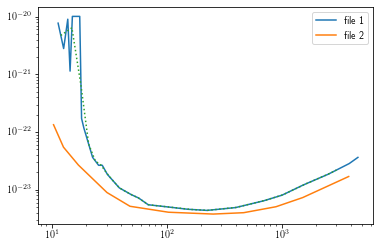

In [3]:
#Get noise power
ligo_sensitivity_dir = './LIGO_sensitivity_data/'
if (ligo_sensitivity == 'default'):
    LIGO_sensitivity_file = 'LIGO_O3.csv' #Hz, Hz^(-0.5)
    #old file
    LIGO_sensitivity_file_2 = 'LIGO_sensitivity.csv' #Hz, Hz^(-0.5)
    LIGO_sensitivity_data = np.genfromtxt(ligo_sensitivity_dir+LIGO_sensitivity_file, delimiter=',')
    LIGO_sensitivity_data_2 = np.genfromtxt(ligo_sensitivity_dir+LIGO_sensitivity_file_2, delimiter=',')
    #Divide by arm length in m
    LIGO_sensitivity_data[:,1] = LIGO_sensitivity_data[:,1]/3994.5
if (ligo_sensitivity == 'old'):
    LIGO_sensitivity_file = 'LIGO_sensitivity.csv' #Hz, Hz^(-0.5)
    LIGO_sensitivity_file_2 = 'LIGO_sensitivity_01_02.csv' #Hz, Hz^(-0.5)
    LIGO_sensitivity_data = np.genfromtxt(ligo_sensitivity_dir+LIGO_sensitivity_file, delimiter=',')
    LIGO_sensitivity_data_2 = np.genfromtxt(ligo_sensitivity_dir+LIGO_sensitivity_file_2, delimiter=',')


#Define interpolation function for LIGO noise
if (1):
    logLIGO_noise_func = interpolate.interp1d(np.log(LIGO_sensitivity_data[:,0]), np.log(LIGO_sensitivity_data[:,1]))

'''
#For testing purposes - as in https://arxiv.org/pdf/gr-qc/9402014.pdf
def logLIGO_noise_func(logf):
    f = np.exp(logf)
    noise_out = np.zeros(len(f))
    lowf = np.where(f < 10)[0]
    highf = np.where(f > 10)[0]
    
    noise_out[lowf] = np.inf
    S0 = 3.0e-48 #1/Hz
    f0 = 70.
    noise_out[highf] = np.log(np.sqrt(S0*((f0/f)**4. + 2.*(1.+(f/f0)**2.))))
    
    return noise_out
'''

fig, ax = pl.subplots(1,1)
ax.plot(LIGO_sensitivity_data[:,0], LIGO_sensitivity_data[:,1], label = 'file 1')
ax.plot(LIGO_sensitivity_data_2[:,0], LIGO_sensitivity_data_2[:,1], label = 'file 2')
nu = np.linspace(12., 3000., num = 1000)
ax.plot(nu, np.exp(logLIGO_noise_func(np.log(nu))), ls = 'dotted')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()



In [4]:
#Build table of rho_optimal

def get_rhoopt(m1, m2, z):
    #get matched filter signal to noise
    #scale by redshift
    #Eq. 1  of https://arxiv.org/pdf/1409.0522.pdf
    
    #Redshift adjusted chirp mass
    DL = cosmo.luminosity_distance(z)
    Mz = (1.+z)*((m1*m2)**(3./5.))/(m1+m2)**(1./5.)
    
    #prefactors
    A = constants.c*np.sqrt(5./96.)*(np.pi**(-2./3.))*(constants.G*Mz/constants.c**3.)**(5./6.)
    
    #frequency range, shouldn't matter too much 
    f_low = 12. #Hz
    f_high = 3000.
    numf = 100
    ff = (1./units.s)*np.exp(np.linspace(np.log(f_low), np.log(f_high), num = numf))
    df = ff[1:] - ff[:-1]
    
    #Noise curve
    LIGO_strain_noise_amplitude = np.exp(logLIGO_noise_func(np.log(ff.value)))*(units.Hz**(-1./2)) #sqrt(1/Hz)
    #fig, ax = pl.subplots(1,1)
    #ax.plot(ff.value, LIGO_psd.value)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    
    #Integral over noise
    Sh = LIGO_strain_noise_amplitude**2.
    integrand = (ff**(-7./3.))/Sh
    if (0):
        fig, ax = pl.subplots(1,1)
        ax.plot(ff, integrand)
        ax.set_xscale('log')
        ax.set_yscale('log')
    I7 = np.sum(0.5*df*(integrand[1:] + integrand[:-1]))
    
    #Antenna pattern
    #https://arxiv.org/pdf/gr-qc/9601048.pdf
    #theta, phi describe orientation of binary relative to detector
    #i, psi describe binary's orientation relative to line of sight between it and detector
    theta = 0. #straight above
    phi = 0. #arbitrary
    cosi =  1.0 #inclination
    psi = 0. #arbitrary
    F_plus = 0.5*(1.+np.cos(theta)**2.)*np.cos(2.*phi)*np.cos(2.*psi) - np.cos(theta)*np.sin(2.*phi)*np.sin(2.*psi)
    F_cross = 0.5*(1.+np.cos(theta)**2.)*np.cos(2.*phi)*np.sin(2.*psi) + np.cos(theta)*np.sin(2.*phi)*np.cos(2.*psi)
    antenna_stuff = ((F_plus**2.)*(1.+cosi**2.)**2. + 4.*(F_cross**2.)*(cosi**2.))
    
    #Signal to noise
    rho2 = 4.*((A**2.)/(DL**2.))*antenna_stuff*I7
    rho = np.sqrt(rho2.to(''))
    #print("SNR = ", rho)

    if (0):
        integrand_test = (4.*((A**2.)/(DL**2.))*antenna_stuff*integrand).to('1/Hz')
    if (0):
        Q = 1.0
        integrand_test = (4.*(constants.c**2.)*(Q**2. / DL**2.)*((constants.G*Mz/constants.c**3)**(5./3.))*integrand).to('1/Hz')
    if (1):
        integrand_test = 0.

    return rho, ff, integrand_test

#test rho opt calculation https://arxiv.org/pdf/gr-qc/9402014.pdf
if (0):
    rhoopt, f_test, int_test = get_rhoopt(10*units.Msun, 20.*units.Msun, 0.1)
    print("rho opt = ", rhoopt)
    
    fig, ax = pl.subplots(1,1)
    ax.plot(f_test, int_test)
    ax.set_xlim((0., 150.))
    

if (1):
    #build table of rho opt vs. m1, m2, z
    minm = 1.0
    maxm = 201.0
    numm = 20
    minz = 0.0002
    maxz = 0.5
    numz = 50
    lnm_list = np.linspace(np.log(minm), np.log(maxm), num = numm)
    lnz_list = np.linspace(np.log(minz), np.log(maxz), num = numz)

    rhoopt_table = np.zeros((numm, numm, numz))
    for m1i in range(0,numm):
        print("m1i = ", m1i)
        for m2i in range(0,numm):
            for zi in range(0, numz):
                rhoopt_table[m1i, m2i, zi], _, _ = \
                    get_rhoopt(np.exp(lnm_list[m1i])*units.Msun, np.exp(lnm_list[m2i])*units.Msun, \
                               np.exp(lnz_list[zi]))

    rhoopt_interp = interpolate.RegularGridInterpolator((lnm_list, lnm_list, lnz_list), rhoopt_table)

if (0):
    #plus and cross
    hp, hc = get_td_waveform(approximant='SEOBNRv2', mass1 = m1, mass2 = m2, spin1z = 0.0, delta_t = 1.0/4096, f_lower = 40)

    fig, ax =  pl.subplots(1,1)
    ax.plot(hp.sample_times, hp)
    

m1i =  0
m1i =  1
m1i =  2
m1i =  3
m1i =  4
m1i =  5
m1i =  6
m1i =  7
m1i =  8
m1i =  9
m1i =  10
m1i =  11
m1i =  12
m1i =  13
m1i =  14
m1i =  15
m1i =  16
m1i =  17
m1i =  18
m1i =  19


201.0
rho_opt =  54.53398716482245


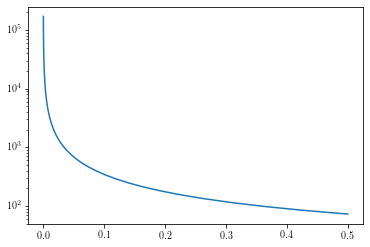

In [5]:
print(np.exp(lnm_list[-1]))
rho_opt, _, _  = get_rhoopt(50*units.Msun,50*units.Msun, 0.2)
print("rho_opt = ", rho_opt)

fig, ax = pl.subplots(1,1)
ax.plot(np.exp(lnz_list), rhoopt_table[-1,-1,:])
ax.set_yscale('log')


In [6]:
#see https://arxiv.org/pdf/1709.08584.pdf


def m1m2_to_chirpeta(m1, m2):
    chirp = ((m1*m2)**(3./5.))/(m1+m2)**(1./5.)
    q = m2/m1
    eta = q/(1.+q)**2.    
    return chirp, eta
    
def chirpeta_to_solve(p0, chirp_desired, eta_desired):
    m1 = p0[0]
    m2 = p0[1]
    chirp, eta = m1m2_to_chirpeta(m1, m2)
    val1 = chirp_desired - chirp
    val2 = eta_desired - eta
    return np.array([val1, val2])

#go from chirp mass and eta to component masses
def chirpeta_to_m1m2(chirp, eta):
    m12 = fsolve(chirpeta_to_solve, [20., 10.], args = (chirp, eta))
    m1 = m12[0]
    m2 = m12[1]
    return m1, m2
    
# generate posterior samples p(m_1, m_2  |  d) given constraint on chirp mass and q,
# where m1 and m2 are source frame masses
def get_m12_samps(measurement_data, num_samp):
    chirp_mean = measurement_data['chirp_mass_mean']
    chirp_err = measurement_data['chirp_mass_err']
    
    q_mean = measurement_data['q_mean']
    q_err = measurement_data['q_err']
       
    # don't get this...90%?
    chirp_sig = chirp_err
    chirp_samples = np.random.normal(loc = chirp_mean, scale = chirp_sig, size = num_samp)
    
    #is this correct?
    if (1):
        q_sig = q_err
        q_samples = np.random.normal(loc = q_mean, scale = q_sig, size = num_samp)
        eta_samples_temp = q_samples/(1.+q_samples)**2.
        if (0):
            eta_mean = np.mean(eta_samples_temp)
            eta_sig = np.std(eta_samples_temp)
            eta_samples= np.random.normal(loc = eta_mean, scale = eta_sig, size = num_samp)
        if (1):
            eta_samples = np.copy(eta_samples_temp)
    
    good = np.where((eta_samples < 0.25) & (eta_samples > 0.))[0]
    
    eta_samples_restrict = eta_samples[good]
    chirp_samples_restrict = chirp_samples[good]
    
    m12_samples = np.zeros((len(eta_samples_restrict),2))
    for ii in range(0,len(eta_samples_restrict)):
        m1, m2 = chirpeta_to_m1m2(chirp_samples_restrict[ii], eta_samples_restrict[ii])
        #print("chirp eta desired = ", chirp_samples[ii], eta_samples[ii])
        #print("chirp eta computed = ", m1m2_to_chirpeta(m1, m2))
        m12_samples[ii, :] = [m1, m2]
        
    if (m12_samples.shape[0] == 1):
        pdb.set_trace()
    
    return m12_samples

#compute spacetime volume
def get_VT(m1, m2):
    q = m2/m1
    q_vals = np.array([0.3, 0.5, 0.7, 1.0])
    scaling_vals = np.array([0.04732198704240483, 0.07268770504529708, \
                             0.086502310513206, 0.09166776119397556])

    q_scaling_func = interpolate.interp1d(q_vals,scaling_vals, bounds_error = False, fill_value = 0.)
    q_scaling = q_scaling_func(q)
    
    return 0.003*q_scaling*m1**(2.2)

def M_max_of_g(g):
    #M_max = 45.*g
    M_max = 70.*g
    return M_max

def param_dict_to_vec(param_dict, param_type):
    #print("param dict = ", param_dict)
    #print("param type = ", param_type)
    if (param_type == 'Mmax'):
        params = np.array([param_dict['alpha'], param_dict['M_max'], param_dict['M_min']])
    if (param_type == 'IMF'):
        params = np.array([param_dict['n1'], param_dict['np'], param_dict['M_max'], param_dict['a'], \
                          param_dict['b'], param_dict['c'], param_dict['d'], param_dict['M_min']])
    if (param_type == 'IMFsimple' or param_type == 'IMFfid'):
        params = np.array([param_dict['n1'], param_dict['np'], param_dict['M_max'], \
                          param_dict['a'], param_dict['b'], param_dict['d'], param_dict['M_min']])
    if (param_type == 'IMFfidsmooth'):
        params = np.array([param_dict['n1'], param_dict['np'], param_dict['M_max'], \
                          param_dict['a'], param_dict['b'], param_dict['d'], param_dict['M_min'], param_dict['delta_m']])        
    if (param_type == 'plandpeak'):
        params = np.array([param_dict['n1'], param_dict['alpha'], param_dict['M_max'], \
                           param_dict['lambda_peak'], param_dict['delta_m'], param_dict['mu_m'],\
                           param_dict['sigma_m'], param_dict['M_min']])
        nn1 = params[0]
        alpha = params[1]
        M_max = params[2]               
        lambda_peak = params[3]
        delta_m = params[4]
        mu_m = params[5]
        sigma_m = params[6]
        M_min = params[7]    
    return params
    
def get_param_dict(params, param_type = 'IMF'):
    if (param_type == 'Mmax'):
        alpha = params[0]

        if (param_type == 'Mmax'):
            M_max = params[1]
        if (param_type == 'g'):
            M_max = M_max_of_g(params[1])
        if (param_type == 'epsilon'):
            M_max = M_max_of_epsilon(params[1])
        if (param_type == 'g3rd'):
            g = params[1]
            M_max = Mgcoef0 + Mgcoef1*g + Mgcoef2*g**2. + Mgcoef3*g**3.
        if (param_type == 'DeltaGmean'):
            g = params[1]
            M_max = Mg_vs_G_mean(g)

        M_min = params[2]

        #M_max_tot choice
        if (M_max_tot_choice == 0):
            M_max_tot = 2.*M_max
        if (M_max_tot_choice == 1):
            M_max_tot = np.min([2.*M_max, 100.])

        param_dict = {'alpha':alpha,\
                      'M_max':M_max,\
                      'M_min':M_min,\
                      'M_max_tot':M_max_tot
                     }
        
    if (param_type == 'IMF' or param_type == 'IMFsimple' or param_type == 'IMFfid' or param_type == 'IMFfidsmooth'):
        nn1 = params[0]
        nnp = params[1]
        M_max = params[2]
        a = params[3]
        b = params[4]
        if (param_type == 'IMF'):
            c = params[5]
            d = params[6]
            M_min = params[7]
        if (param_type == 'IMFsimple' or param_type == 'IMFfid' or param_type == 'IMFfidsmooth'):
            d = params[5]
            M_min = params[6]
        if (param_type == 'IMFfidsmooth'):
            delta_m = params[7]

        #M_max_tot choice
        if (M_max_tot_choice == 0):
            M_max_tot = 2.*M_max
        if (M_max_tot_choice == 1):
            M_max_tot = np.min([2.*M_max, 100.])        
        
        param_dict = {
              'n1':nn1,\
              'np':nnp, \
              'M_max':M_max,\
              'a':a,\
              'b':b,\
              'd':d,\
              'M_min':M_min,\
              'M_max_tot':M_max_tot
             }
        if (param_type == 'IMF'):
            param_dict['c'] = c
        if (param_type == 'IMFfidsmooth'):
            param_dict['delta_m'] = delta_m
            
        
    if (param_type == 'plandpeak'):
        nn1 = params[0]
        alpha = params[1]
        M_max = params[2]               
        lambda_peak = params[3]
        delta_m = params[4]
        mu_m = params[5]
        sigma_m = params[6]
        M_min = params[7]
                
        #M_max_tot choice
        if (M_max_tot_choice == 0):
            M_max_tot = 2.*M_max
        if (M_max_tot_choice == 1):
            M_max_tot = np.min([2.*M_max, 100.])
        
        param_dict = {
              'n1':nn1,\
              'alpha':alpha,\
              'M_max':M_max,\
              'lambda_peak':lambda_peak,\
              'delta_m':delta_m,\
              'mu_m':mu_m,\
              'sigma_m':sigma_m,\
              'M_min':M_min,\
              'M_max_tot':M_max_tot
             }
        
    return param_dict

def get_mass_distrib_old(m1, m2, params, param_type = 'Mmax'):
    param_dict = get_param_dict(params, param_type)
    alpha = param_dict['alpha']
    M_max = param_dict['M_max']
    M_max_tot = param_dict['M_max_tot']
    M_min = param_dict['M_min']

    if (np.isscalar(m1)):
        if (not np.isscalar(m1)):
            pdb.set_trace()
        step_func = (m1 < M_max) + np.zeros(len(m2))
        
        if (m1 < M_max_tot - m1):
            minfunc = m1
        if (m1 >= M_max_tot - m1):
            minfunc = M_max_tot - m1
    else:
        step_func = np.zeros(len(m1))
        below_Mmax = np.where(m1 < M_max)[0]
        step_func[below_Mmax] = 1.0
        
        minfunc = np.zeros(len(m1))
        smallm1 = np.where(m1 < M_max_tot - m1)[0]
        largem1 = np.where(m1 > M_max_tot - m1)[0]
        minfunc[smallm1] = m1[smallm1]
        minfunc[largem1] = (M_max_tot - m1)[largem1]
            
    mtot_constraint = 1.0+np.zeros(len(step_func))
    bad = np.where(m1+m2 > M_max_tot)[0]
    mtot_constraint[bad] = 0.0
    
    p12 = (m1**(-alpha))*step_func*mtot_constraint/(minfunc - M_min)
    
    return p12


def get_secondary_dndm(m1, params, param_type = 'IMF'):
    param_dict = get_param_dict(params, param_type)
    nn1 = param_dict['n1']
    nnp = param_dict['np']
    M_max = param_dict['M_max']
    M_min = param_dict['M_min']
    M_max_tot = param_dict['M_max_tot']
    a = param_dict['a']
    b = param_dict['b']
    d = param_dict['d']    
    delta_m = 0.
    if (param_type == 'IMFfidsmooth'):
        delta_m = param_dict['delta_m']    
    
    #dNdM secondary
    if (secondary_type != 'physical'):
        dNdM_secondary =  (10.**nnp)*((m1/30.)**d)
    if (secondary_type == 'physical'):
        if (np.isscalar(m1)):
            step1 = 0.
            step2 = 0.
            if (m1 >= fudge*M_max and m1 <= M_max + M_min + delta_m/2.):
                step1 = 1
            if (m1 > M_max + M_min + delta_m/2.):
                step2 = 1.
        else:
            step1 = np.zeros(len(m1))
            step2 = np.zeros(len(m1))
            mid = np.where((m1 >= fudge*M_max) & (m1 <= M_max + M_min + delta_m/2.))[0]
            high = np.where(m1 > M_max + M_min + delta_m/2.)[0]
            step1[mid] = 1.
            step2[high] = 1.

        dNdM_secondary = (10.**nnp)*(step1 + step2*(m1/(M_min + M_max + delta_m/2.))**d)
        
    return dNdM_secondary
    
def get_smoothing(mm, M_min, delta_m):
    #delta_m = param_dict['delta_m']
    mprime = mm - M_min
    if (np.isscalar(mm)):
        if (mm <= M_min):
            S_m = 0.
        elif (mm > M_min + delta_m):
            S_m = 1.0
        else:
            arg = (delta_m/mprime) + (delta_m/(mprime - delta_m))
            if (arg < 100.):
                f_m = np.exp(arg)
                S_m = 1./(f_m+1.)
            else:
                S_m = 0.
    else:
        S_m = np.zeros(mm.shape)
        low = np.where(mm <= M_min)[0]
        mid = np.where((mm > M_min) & (mm < M_min + delta_m))[0]
        high = np.where(mm >= M_min + delta_m)[0]
        S_m[low] = 0.
        arg = (delta_m/mprime[mid]) + (delta_m/(mprime[mid] - delta_m))
        good = np.where(arg < 100.)[0]
        f_m_good = np.exp(arg[good])
        S_m[mid[good]] = 1./(f_m_good+1.)
        S_m[high] = 1.0
    return S_m

#p(m_1, m_2 | M_max, alpha)
def get_mass_distrib(m1, m2, params, param_type = 'IMF', return_dndm = False, return_1g2g = False, verbose = False):
    #m1 is scalar - this happens when computing beta     
    #m1 is array - happens when computing weights       
    
    param_dict = get_param_dict(params, param_type)

    #Constraint shared by all models
    M_max_tot = param_dict['M_max_tot']
    if (np.isscalar(m1)):
        if (m1 < M_max_tot - m1):
            minfunc = m1
        if (m1 >= M_max_tot - m1):
            minfunc = M_max_tot - m1     
    else:
        minfunc = np.zeros(len(m1))
        smallm1 = np.where(m1 < M_max_tot - m1)[0]
        largem1 = np.where(m1 > M_max_tot - m1)[0]
        minfunc[smallm1] = m1[smallm1]
        minfunc[largem1] = (M_max_tot - m1)[largem1]
    
    if (param_type == 'Mmax'):
        alpha = param_dict['alpha']
        M_max = param_dict['M_max']
        M_max_tot = param_dict['M_max_tot']
        M_min = param_dict['M_min']

        #m1 is scalar and m2 is array
        if (np.isscalar(m1)):
            step_func = (m1 < M_max) + np.zeros(len(m2))
        
        #m1 is array and m2 is ????
        else:
            step_func = np.zeros(len(m1))
            below_Mmax = np.where(m1 < M_max)[0]
            step_func[below_Mmax] = 1.0

        mtot_constraint = 1.0+np.zeros(len(step_func))
        bad = np.where(m1+m2 > M_max_tot)[0]
        mtot_constraint[bad] = 0.0

        p12 = (m1**(-alpha))*step_func*mtot_constraint/(minfunc - M_min)
        
        negative = np.where(p12 < 0.)
        if (len(negative) > 0):
            p12[negative] = 0.
        
    if (param_type == 'IMF' or param_type == 'IMFsimple' or param_type == 'IMFfid' or param_type == 'IMFfidsmooth'):
        nn1 = param_dict['n1']
        nnp = param_dict['np']
        M_max = param_dict['M_max']
        M_min = param_dict['M_min']
        M_max_tot = param_dict['M_max_tot']
        a = param_dict['a']
        b = param_dict['b']
        if (param_type == 'IMF'):
            c = param_dict['c']
        d = param_dict['d']     
        
        #dNdM primary
        if (param_type == 'IMF'):
            dNdM_primary = nn1*((m1/30.)**b)*(1.+a*((m1/30.)**c)*((M_max-m1)/20.)**(a-1.))
        if (param_type == 'IMFsimple'):
            term_numerator = ((M_max - m1)**(a-1.))*(M_max**0.5)
            term_denominator = 2.*M_max**(a - 0.5)
            dNdM_primary = nn1*((m1/30.)**b)*(1.+term_numerator/term_denominator)
        if (param_type == 'IMFfid' or param_type == 'IMFfidsmooth'):
            #term1 = a*np.sqrt(m1)*(M_max**(0.5-a))  #77777777777777777777
            if (np.isscalar(m1)):
                if (fudge_type == 'flat'):
                    if (m1 < fudge*M_max):
                        term1 = 2.*(a**2.)*np.sqrt(m1)*(M_max**(0.5-a))
                        term2 = (M_max - m1)**(a-1.)
                        dNdM_primary = nn1*((m1/30.)**b)*(1.+term1*term2)
                    if (m1 >= fudge*M_max and m1 <= M_max):
                        m1_temp = fudge*M_max
                        term1 = 2.*(a**2.)*np.sqrt(m1_temp)*(M_max**(0.5-a))
                        term2 = (M_max - m1_temp)**(a-1.)
                        dNdM_primary = nn1*((m1_temp/30.)**b)*(1.+term1*term2)
                    if (m1 > M_max):
                        dNdM_primary = 0.                        
                if (fudge_type == 'sharp'):
                    if (m1 < fudge*M_max):
                        term1 = 2.*(a**2.)*np.sqrt(m1)*(M_max**(0.5-a))
                        term2 = (M_max - m1)**(a-1.)
                        dNdM_primary = nn1*((m1/30.)**b)*(1.+term1*term2)
                    if (m1 > fudge*M_max):
                        dNdM_primary = 0.
            if (not np.isscalar(m1)):
                if (fudge_type == 'flat'):
                    low = np.where(m1 < fudge*M_max)[0]
                    mid = np.where((m1 >= fudge*M_max) & (m1 <= M_max))[0]
                    #high = np.where(m1 > M_max)[0]
                    dNdM_primary = np.zeros(len(m1))

                    term1_low = 2.*(a**2.)*np.sqrt(m1[low])*(M_max**(0.5-a))
                    term2_low = (M_max - m1[low])**(a-1.)
                    dNdM_primary_low = nn1*((m1[low]/30.)**b)*(1.+term1_low*term2_low)

                    m1_mid_temp = fudge*M_max
                    term1_mid = 2.*(a**2.)*np.sqrt(m1_mid_temp)*(M_max**(0.5-a))
                    term2_mid = (M_max - m1_mid_temp)**(a-1.)
                    dNdM_primary_mid = nn1*((m1_mid_temp/30.)**b)*(1.+term1_mid*term2_mid)

                    dNdM_primary[low] = dNdM_primary_low
                    dNdM_primary[mid] = dNdM_primary_mid
                if (fudge_type == 'sharp'):
                    low = np.where(m1 < fudge*M_max)[0]
                    dNdM_primary = np.zeros(len(m1))
                    term1_low = 2.*(a**2.)*np.sqrt(m1[low])*(M_max**(0.5-a))
                    term2_low = (M_max - m1[low])**(a-1.)
                    dNdM_primary_low = nn1*((m1[low]/30.)**b)*(1.+term1_low*term2_low)
                    dNdM_primary[low] = dNdM_primary_low
                
        #Get smoothing function for m1
        if (param_type == 'IMFfidsmooth'):
            delta_m = param_dict['delta_m']
            S_m = get_smoothing(m1, M_min, delta_m)
        
        if (np.isscalar(m1)):
            if (m1 > fudge*M_max):
                dNdM_primary = 0.

            mtot_constraint = 1.0+np.zeros(len(m2))
            bad = np.where(m1+m2 > M_max_tot)[0]
            mtot_constraint[bad] = 0.0       
        else:
            above_Mmax = np.where(m1 > fudge*M_max)[0] 
            dNdM_primary[above_Mmax] = 0.
            
            mtot_constraint = 1.0+np.zeros(len(m1))
            bad = np.where(m1+m2 > M_max_tot)[0]
            mtot_constraint[bad] = 0.0
        
        #Mass function for secondary population
        dNdM_secondary = get_secondary_dndm(m1, params, param_type = param_type)
        
        if (param_type == 'IMFfidsmooth'):
            dNdM_primary *= S_m
        
        #total dNdM
        dNdM = dNdM_primary + dNdM_secondary

        # Make sure everything is well behaved
        if (np.isscalar(dNdM)):
            if (dNdM < 0.):
                dNdM = 0.
            if (np.isnan(dNdM)):
                dNdM = 0
        else:
            negative = np.where(dNdM < 0.)[0]
            if (len(negative) > 0):
                dNdM[negative] = 0.
            #Can go NAN for M > M_BHMG
            nans = np.where(np.isnan(dNdM))[0]
            if (len(nans) > 0):
                dNdM[nans] = 0.
        
        #WHY DOESNT EQ 1 OF FISHBACH & HOLZ HAVE NORMALIZATION PREFACTORS, DONT THOSE MATTER?
        #No, because any function of params in normalization will cancel out via beta
        pm2_given_m1 = mtot_constraint/(minfunc - M_min)
        
        #If needed, apply smoothing to conditional distribution as well
        if (param_type == 'IMFfidsmooth'):
            S_m2 = get_smoothing(m2, M_min, delta_m)            
            pm2_given_m1 *= S_m2
        
        p12 = dNdM*pm2_given_m1
           
        inf_locs = np.where(np.isinf(p12))
        p12[inf_locs] = 0.0        
        
    if (param_type == 'plandpeak'):
        nn1 = param_dict['n1']
        alpha = param_dict['alpha']
        M_max = param_dict['M_max']
        M_max_tot = param_dict['M_max_tot']
        M_min = param_dict['M_min']
        lambda_peak = param_dict['lambda_peak']
        delta_m = param_dict['delta_m']
        mu_m = param_dict['mu_m']
        sigma_m = param_dict['sigma_m']
               
        #Smoothing functions
        S_m = get_smoothing(m1, M_min, delta_m)
        S_m2 = get_smoothing(m2, M_min, delta_m)
        
        if (np.isscalar(m1)):
            mtot_constraint = 1.0+np.zeros(len(m2))
            bad = np.where(m1+m2 > M_max_tot)[0]
            mtot_constraint[bad] = 0.0
            
            step_func = (m1 < M_max) + np.zeros(len(m2))
        else:
            mtot_constraint = 1.0+np.zeros(len(m1))
            bad = np.where(m1+m2 > M_max_tot)[0]
            mtot_constraint[bad] = 0.0
        
            step_func = np.zeros(len(m1))
            below_Mmax = np.where(m1 < M_max)[0]
            step_func[below_Mmax] = 1.0
        
        #Truncated power law
        normalization = 1./(((M_max**(1-alpha))/(1.-alpha)) - ((M_min**(1-alpha))/(1.-alpha)))
        B_powerlaw = normalization*step_func*(m1**(-alpha))
        G_peak = (1./np.sqrt(2.*np.pi*sigma_m**2.))*np.exp(-0.5*((m1-mu_m)/sigma_m)**2.)
                
        if (verbose):
            print("delta_m = ", delta_m)
            print("f_m = ", f_m)
        
        dNdM = ((1-lambda_peak)*B_powerlaw + lambda_peak*G_peak)*S_m
        
        #including smoothing for secondary
        pm2_given_m1 = S_m2*mtot_constraint/(minfunc - M_min)
        p12 = dNdM*pm2_given_m1

        inf_locs = np.where(np.isinf(p12))
        p12[inf_locs] = 0.0

    negative = np.where(p12 < 0.)
    if (len(negative) > 0):
        p12[negative] = 0.            
  
    if (not return_1g2g):
        if (not return_dndm):
            return p12
        else:
            return p12, dNdM
    else:
        return p12, dNdM_primary, dNdM_secondary


# compute beta
def get_beta_old(params, param_type = 'Mmax'):
    param_dict = get_param_dict(params, param_type)
    alpha = param_dict['alpha']
    M_max = param_dict['M_max']
    M_max_tot = param_dict['M_max_tot']
    M_min = param_dict['M_min']
        
    # Do 2D integral over m1 and m2
    min_m1 = M_min*1.001
    max_m1 = M_max
    num_m1 = 100
    num_m2 = 100
    m1 = np.linspace(min_m1, max_m1, num = num_m1)
    dm1 = m1[1:] - m1[:-1]
    integrand_over_m2 = np.zeros(num_m1)
    for m1i in range(0, num_m1):
        min_m2 = M_min
        this_m1 = m1[m1i]
        max_m2 = np.min([this_m1,M_max_tot - this_m1])
        m2 = np.linspace(min_m2, max_m2, num = num_m2)
        dm2 = m2[1:]-m2[:-1]
        integrand = get_mass_distrib(this_m1, m2, params, param_type = param_type)*get_VT(this_m1, m2)
        integrand_over_m2[m1i] = np.sum(0.5*dm2*(integrand[1:] + integrand[:-1])) 
    beta = np.sum(0.5*dm1*(integrand_over_m2[1:] + integrand_over_m2[:-1]))
    
    return beta

# compute beta
def get_beta(params, param_type = 'IMF'):
    param_dict = get_param_dict(params, param_type)
    #alpha = param_dict['alpha']
    M_max = param_dict['M_max']
    M_max_tot = param_dict['M_max_tot']
    M_min = param_dict['M_min']
        
    # Do 2D integral over m1 and m2
    min_m1 = M_min*1.001
    if (param_type == 'Mmax'):
        max_m1 = M_max
        num_m1 = 100
        num_m2 = 100
    if (param_type == 'IMF' or param_type == 'IMFsimple' or \
        param_type == 'IMFfid' or param_type == 'plandpeak' or param_type == 'IMFfidsmooth'):
        if (np.isscalar(M_max)):
            max_m1 = M_max_tot
        else:
            max_m1 = M_max_tot + np.zeros(len(M_max))
        num_m1 = 2000
        num_m2 = 200
    m1 = np.linspace(min_m1, max_m1, num = num_m1)

    dm1 = m1[1:] - m1[:-1]
    integrand_over_m2 = np.zeros(num_m1)
    for m1i in range(0, num_m1):
        min_m2 = M_min
        this_m1 = m1[m1i]
        max_m2 = np.min([this_m1,M_max_tot - this_m1])
        m2 = np.linspace(min_m2, max_m2, num = num_m2)
        if (max_m2 > min_m2):
            dm2 = m2[1:]-m2[:-1]
            if (0):
                integrand = get_mass_distrib(this_m1, m2, params, param_type = param_type)*\
                    get_VT(this_m1, m2)
            if (0):
                m1_array = this_m1 + np.zeros(len(m1))
                integrand = get_mass_distrib(this_m1, m2, params, param_type = param_type)*\
                    get_VT_true(m1_array, m2)
            if (1):
                integrand = get_mass_distrib(this_m1, m2, params, param_type = param_type)*\
                    get_VT_true_interp(this_m1, m2)[0,:]    

            integrand_over_m2[m1i] = np.sum(0.5*dm2*(integrand[1:] + integrand[:-1])) 
    beta = np.sum(0.5*dm1*(integrand_over_m2[1:] + integrand_over_m2[:-1]))
    #fig, ax = pl.subplots(1,1)
    #ax.plot(m1, integrand_over_m2)
    return beta

# compute data likelihood given posterior samples on m1 and m2
def data_likelihood(params, m12_samps, param_type = 'IMF', return_weights = False, verbose = False, beta = None):
    #normalization factor
    if (beta is None):
        beta = get_beta(params, param_type = param_type)
    
    # weights are p(m_1, m_2 | M_max, alpha)
    m1 = m12_samps[:,0]
    m2 = m12_samps[:,1]
    weights = get_mass_distrib(m1, m2, params, param_type = param_type, verbose = verbose)
    if (verbose):
        print("max(weights) = ", np.max(weights))
        print("beta = ", beta)
    
    '''
    fig, ax = pl.subplots(1,1)
    ax.hist((weights/beta))
    ax.set_yscale('log')
    
    fig, ax = pl.subplots(1,1)
    ax.plot(m1, weights/beta, 'b,')
    ax.set_yscale('log')
    '''
    
    # likelihood related to average over posterior samples   
    likelihood = np.mean(weights)/beta
    
    if (likelihood < 0.):
        print("LIKELIHOOD IS NEGATIVE WTF")
        pdb.set_trace()
        
    if (np.isnan(likelihood)):
        #print("lnlike is nan")
        likelihood = badval
    if (likelihood > 1.0e100):
        print("lnlike > 1.0e100")

    if (not return_weights):
        return likelihood
    if (return_weights):
        return likelihood, weights


def get_minmax(param_type = 'IMF'):
    if (param_type == 'Mmax'):
        min_dict = {'alpha':0.,\
                    'M_max':0.1,\
                    'M_min':30.}
        max_dict = {'alpha':10.,\
                    'M_max':100.,\
                    'M_min':10.}
        
    if (param_type == 'IMF' or param_type == 'IMFsimple' or \
        param_type == 'IMFfid' or param_type == 'IMFfidsmooth'):
        min_dict = {'n1':0.,\
                    'np':-4.,\
                    'M_max':30.,\
                    'M_min':0.,\
                    'a':0.0,\
                    'b':-4.,\
                    'd':-5.}  
        max_dict = {'n1':10.,\
                    'np':1.,\
                    'M_max':100.,\
                    'M_min':10.,\
                    #'a':1.0,\#777777777777777777777
                    'a':0.5, \
                    'b':0.,\
                    'd':0.}
        if (param_type == 'IMF'):
            min_dict['c'] = 0.
            max_dict['c'] = 10.
        if (param_type == 'IMFfidsmooth'):
            min_dict['delta_m'] = 0.
            max_dict['delta_m'] = 10.
    if (param_type == 'plandpeak'):
        min_dict = {'n1':0.,\
                    'alpha':-4.,\
                    'M_max':30.,\
                    'M_min':0.,\
                    'lambda_peak':0.,\
                    'delta_m':0.,\
                    'mu_m':20.,\
                    'sigma_m':0.4}
        max_dict = {'n1':10.,\
                    'alpha':12.,\
                    'M_max':100.,\
                    'M_min':10.,\
                    'lambda_peak':1.,\
                    'delta_m':10.,\
                    'mu_m':50.,\
                    'sigma_m':10.0}        

    min_vals = param_dict_to_vec(min_dict, param_type)
    max_vals = param_dict_to_vec(max_dict, param_type)
    
    return min_vals, max_vals
        
    
def get_lnprior(params, param_type = 'IMF', verbose = False):
    param_dict = get_param_dict(params, param_type)
    lnprior = 0.

    min_vals, max_vals = get_minmax(param_type = param_type)
    outside_prior = np.where((params <= min_vals) | (params >= max_vals))[0]
    if (len(outside_prior) > 0):
        lnprior = badval
        if (verbose):
            print(outside_prior)
            print(min_vals)
            print(max_vals)
            print(params)
            
    #if (param_type == 'IMF' or param_type == 'IMFsimple' \
    #    or param_type == 'IMFfid' or param_type == 'IMFfidsmooth'):
    #    param_dict = get_param_dict(params, param_type)
    #    if (param_dict['d'] < param_dict['b']):
    #        lnprior = -1.0e100

    return lnprior


def get_lnlikelihood(params, data, param_type = 'IMF', verbose = False):
    '''
    Evaluate total likelihood at particular point in paramaeter space.  Data is list of BH measurements.
    '''
    #Beta only depends on parameters
    beta = get_beta(params, param_type = param_type)
    
    like_arr = np.zeros(len(data))
    for ii in range(0,len(data)):
        if ('chirp_mass_mean' in bh_data[ii]):
            m12_samples = get_m12_samps(bh_data[ii], 100)
        else:
            m12_samples = bh_data[ii]['m12_samples']

        this_like = data_likelihood(params, m12_samples, beta = beta, param_type = param_type, verbose = verbose)
        like_arr[ii]= this_like

    super_low_likelihood = np.where(like_arr <= 0.)[0]
    if (len(super_low_likelihood) > 0):
        lnlike_tot = badval
    else:
        lnlikes = np.log(like_arr)
        lnlike_tot = np.sum(lnlikes)
    
    return lnlike_tot

def get_lnposterior(params, data, param_type = 'IMF', verbose = False):
    '''
    Evaluate total posterior at particular point in parameter space.  Data is list of BH measurements.
    '''
    lnprior = get_lnprior(params, param_type = param_type, verbose=verbose)
    if (lnprior < -1.0e20):
        lnlike_tot = badval #doesn't matter, since prior is totall dominant
    else:
        lnlike_tot = get_lnlikelihood(params, data, param_type = param_type)
    if (verbose):
        print("lnlike_tot = ", lnlike_tot)
        print("lnprior = ", lnprior)
        
    return lnlike_tot + lnprior

def sample_lnposterior(params, input_data, fix_param_values, free_indices, param_type):
    #leave one out analysis
    param_vals = np.copy(fix_param_vals)
    param_vals[free_indices] = params

    if (do_loo):
        data = np.delete(input_data, loo_index)
        loo_lnlike = get_lnlikelihood(param_vals, [data[loo_index]], param_type = param_type)
    else:
        data = np.copy(input_data)
    
    lnpost = get_lnposterior(param_vals, data, param_type = param_type)
    if (not np.isfinite(lnpost)):
        lnpost = badval

    if (do_loo):
        return lnpost, loo_lnlike
    
    return lnpost

def sample_neglnposterior(params, data, fix_param_values, free_indices, param_type):
    param_vals = np.copy(fix_param_vals)
    param_vals[free_indices] = params
    lnpost = get_lnposterior(param_vals, data, param_type = param_type)
    if (not np.isfinite(lnpost)):
        lnpost = badval
    print("-lnpost = ", -lnpost)
    return -lnpost

def sample_lnlikelihood(params, data, fix_param_values, free_indices, param_type):
    param_vals = np.copy(fix_param_vals)
    param_vals[free_indices] = params
    lnlikelihood = get_lnlikelihood(param_vals, data, param_type = param_type)
    if (not np.isfinite(lnlikelihood)):
        lnlikelihood = badval
    return lnlikelihood

def sample_lnposterior_polychord(params):
    data = polychord_dict['data']
    param_type = polychord_dict['param_type']
    fix_param_values = polychord_dict['fix_param_values']
    free_indices = polychord_dict['free_indices']
    
    param_vals = np.copy(fix_param_vals)
    param_vals[free_indices] = params
    
    # Why is this needed?
    r2 = np.sum(params**2)
    
    lnpost = get_lnposterior(param_vals, data, param_type = param_type)
    if ((lnpost < -1.0e20) or (not np.isfinite(lnpost))):
            lnpost = badval
            
    return lnpost, [r2]


In [7]:
#Make posterior samples from values in table
if (data_type == 'chirp_mean_old'):
    bh_data = [ #first one comes from other paper
        #source frame numbers
        {'chirp_mass_mean':21.1, 'chirp_mass_err':2.5, 'q_mean':0.5, 'q_err':0.18}, \
        {'chirp_mass_mean':28.1, 'chirp_mass_err':1.7, 'q_mean':0.81, 'q_err':0.18}, \
        {'chirp_mass_mean':8.88, 'chirp_mass_err':0.3, 'q_mean':0.52, 'q_err':0.35}, \
        {'chirp_mass_mean':15.1, 'chirp_mass_err':1.3, 'q_mean':0.57, 'q_err':0.37} \
        ]

#Use LIGO chains to get posterior samples
if (data_type == 'LIGOchains'):
    BBHs = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729',  'GW170809', 'GW170814', 'GW170818', 'GW170823']
    bh_data = []
    for ii in range(0,len(BBHs)):
        a_BBH =  BBHs[ii]
        BBH_file = './LIGO/GWTC-1_sample_release/'+a_BBH+'_GWTC-1.hdf5'
        BBH = h5py.File(BBH_file, 'r')

        print("a_BBH = ", a_BBH)

        min_z = 0.
        max_z = 5.0
        numz = 1000
        z_table = np.linspace(min_z, max_z, num = numz)
        d_L_table = cosmo.luminosity_distance(z_table)
        z_func = interpolate.interp1d(d_L_table, z_table)

        z_list = z_func(BBH['Overall_posterior']['luminosity_distance_Mpc'])
        print("mean z = ", np.mean(z_list))
        
        m1_detector = BBH['Overall_posterior']['m1_detector_frame_Msun']
        m2_detector = BBH['Overall_posterior']['m2_detector_frame_Msun']
        m1_source = m1_detector/(1.+z_list)
        m2_source = m2_detector/(1.+z_list)

        #print("m1 (detector) = ", np.median(m1_detector), np.median(m1_detector) - np.percentile(m1_detector, 5), np.percentile(m1_detector, 95) - np.median(m1_detector))
        #print("m1 (source) = ", np.median(m1_source), np.median(m1_source) - np.percentile(m1_source, 5), np.percentile(m1_source, 95) - np.median(m1_source))
        m12_samples = np.vstack((m1_source, m2_source)).transpose()
        #print(m12_samples.shape)
        bh_data.append({'m12_samples':m12_samples})

        
#Make posterior samples from values in table
if (data_type == 'chirp_mean_old'):
    bh_data = [ #first one comes from other paper
        #source frame numbers
        {'chirp_mass_mean':21.1, 'chirp_mass_err':2.5, 'q_mean':0.5, 'q_err':0.18}, \
        {'chirp_mass_mean':28.1, 'chirp_mass_err':1.7, 'q_mean':0.81, 'q_err':0.18}, \
        {'chirp_mass_mean':8.88, 'chirp_mass_err':0.3, 'q_mean':0.52, 'q_err':0.35}, \
        {'chirp_mass_mean':15.1, 'chirp_mass_err':1.3, 'q_mean':0.57, 'q_err':0.37} \
        ]

#Use LIGO chains to get posterior samples
if (data_type == 'LIGOchains' or data_type == 'LIGOchains2'):
    BBHs = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729',  'GW170809', 'GW170814', 'GW170818', 'GW170823']
    bh_data_O1 = []
    for ii in range(0,len(BBHs)):
        a_BBH =  BBHs[ii]
        BBH_file = './LIGO/GWTC-1_sample_release/'+a_BBH+'_GWTC-1.hdf5'
        BBH = h5py.File(BBH_file, 'r')

        print("a_BBH = ", a_BBH)

        min_z = 0.
        max_z = 5.0
        numz = 1000
        z_table = np.linspace(min_z, max_z, num = numz)
        d_L_table = cosmo.luminosity_distance(z_table)
        z_func = interpolate.interp1d(d_L_table, z_table)

        z_list = z_func(BBH['Overall_posterior']['luminosity_distance_Mpc'])
        print("mean z = ", np.mean(z_list))
        
        m1_detector = BBH['Overall_posterior']['m1_detector_frame_Msun']
        m2_detector = BBH['Overall_posterior']['m2_detector_frame_Msun']
        m1_source = m1_detector/(1.+z_list)
        m2_source = m2_detector/(1.+z_list)

        #print("m1 (detector) = ", np.median(m1_detector), np.median(m1_detector) - np.percentile(m1_detector, 5), np.percentile(m1_detector, 95) - np.median(m1_detector))
        #print("m1 (source) = ", np.median(m1_source), np.median(m1_source) - np.percentile(m1_source, 5), np.percentile(m1_source, 95) - np.median(m1_source))
        m12_samples = np.vstack((m1_source, m2_source)).transpose()
        #print(m12_samples.shape)
        bh_data_O1.append({'m12_samples':m12_samples, 'name':BBHs[ii]})
        
#Use LIGO updated chains to get posterior samples
if (data_type == 'LIGOchains2'):
    
    prev_filename = 'bh_data_wname_saved_temp'    
    
    exclude_names = ['GW170817','GW190425','GW190814', 'GW190909_114149', 'GW190719_215514', 'GW190426_152155']

    load_data = True
    if (load_data):
        base_dir = './LIGO_chain_data/'
        bh_data = np.load(base_dir + prev_filename + '.npy', allow_pickle=True)
        m1_means = np.zeros(len(bh_data))
        m1_mins = np.zeros(len(bh_data))
        for ii in range(0,len(bh_data)):
            m1_means[ii] = np.mean(bh_data[ii]['m12_samples'][:,0])
            m1_mins[ii] = np.min(bh_data[ii]['m12_samples'][:,0])
        
        bh_data = np.append(bh_data_O1, bh_data)
        
        bad = np.zeros(len(bh_data))
        index_190521 = np.zeros(2)
        counter_190521 = 0
        for ii in range(0,len(bh_data)):
            print(bh_data[ii]['name'])
            for jj in range(0,len(exclude_names)):
                if (exclude_names[jj] in bh_data[ii]['name']):
                    bad[ii] = 1
                    print("bad bh_data[ii]['name']")
            if (bh_data[ii]['name'] == 'GW190521_comoving.h5'):
                index_190521[counter_190521] = ii
                counter_190521 = counter_190521 + 1
                print("190521 excluded!!!!!!")
                    
        print(bad)
        to_include = np.where(bad == 0)[0]
        bh_data = bh_data[to_include]
        
        if (exclude_190521):
            bh_data = np.delete(bh_data, index_190521.astype('int'))
                
    
    if (not load_data):
        base_dir = '/Users/ebax/Documents/LIGOchains/all_posterior_samples/'
        all_files = os.listdir(base_dir)
        comoving_files = []
        for fi in all_files:
            if ('comoving.h5' in fi):
                comoving_files.append(fi)    

        bh_data = []
        used_file = []
        #for ii in range(0,2):
        for ii in range(0,len(comoving_files)):
            print("ii = ", ii)
            file_ii =  comoving_files[ii]
            BBH_file = base_dir + file_ii
            print(BBH_file)
            data = read(BBH_file)

            samples_dict = data.samples_dict
            if ('PrecessingSpinIMRHM' in samples_dict):
                posterior_samples = samples_dict['PrecessingSpinIMRHM']
                m1_source = posterior_samples['mass_1_source']
                m2_source = posterior_samples['mass_2_source']        

                m12_samples = np.vstack((m1_source, m2_source)).transpose()
                bh_data.append({'m12_samples':m12_samples})  
                
                used_files.append(BBH_file)
            else:
                print("data not found!  ", BBH_file)
        np.save(base_dir + prev_filename, bh_data)
        
#weird  GW190909_114149_comoving.h5, GW190719_215514_comoving.h5, GW190426_152155_comoving.h5

print(len(bh_data))

#77777777777777777777777777777777777777777777777777
bh_data = np.delete(bh_data, 0)

print(len(bh_data))

a_BBH =  GW150914
mean z =  0.09206612865834018
a_BBH =  GW151012
mean z =  0.21238637299684562
a_BBH =  GW151226
mean z =  0.0936175303049475
a_BBH =  GW170104
mean z =  0.19492121886941813
a_BBH =  GW170608
mean z =  0.0696120547167528
a_BBH =  GW170729
mean z =  0.48740962447379543
a_BBH =  GW170809
mean z =  0.19981240951589518
a_BBH =  GW170814
mean z =  0.12131406661905424
a_BBH =  GW170818
mean z =  0.20915760182606485
a_BBH =  GW170823
mean z =  0.3532330633405981
GW150914
GW151012
GW151226
GW170104
GW170608
GW170729
GW170809
GW170814
GW170818
GW170823
GW190517_055101_comoving.h5
GW190706_222641_comoving.h5
GW190521_074359_comoving.h5
GW190412_comoving.h5
GW190413_134308_comoving.h5
GW190731_140936_comoving.h5
GW190929_012149_comoving.h5
GW190602_175927_comoving.h5
GW190527_092055_comoving.h5
GW190620_030421_comoving.h5
GW190421_213856_comoving.h5
GW190521_comoving.h5
190521 excluded!!!!!!
GW190630_185205_comoving.h5
GW190909_114149_comoving.h5
bad bh_data[ii]['name']
GW190915_

In [8]:
def get_Pw(ww):
    #See Appendix of Dominik et al. 2015 https://arxiv.org/pdf/1405.7016.pdf
    
    a2 = 0.374222
    a4 = 2.04216
    a8 = -2.63948
    alpha = 1.0
    
    Pw = a2*(1-ww/alpha)**2. + a4*(1.-ww/alpha)**4. + a8*(1.-ww/alpha)**8. + (1-a2-a4-a8)*(1.-ww/alpha)**10.
    
    return Pw

def get_VT_true(m1, m2):
    #m1 and m2 should have same length

    VT = np.zeros(len(m1))

    #These don't matter since we're not sensitive to overall proportionality
    T = 1.0 #search time in years
    dOmega = 4.*np.pi #sky area

    minz = 0.0002
    maxz = 0.5 
    numz = 100
    zz = np.exp(np.linspace(np.log(minz), np.log(maxz), num = numz))
    dz = zz[1:] - zz[:-1]

    chi = cosmo.comoving_distance(zz)
    D_A = cosmo.angular_diameter_distance(zz)
    H_z = cosmo.H(zz)

    # in Gpc^3
    dVc_dz = ((constants.c)*dOmega*((1.+zz)**2.)*(D_A**2.)/H_z).to('Gpc**3').value
    
    #random angular factors to account for source not overhead
    num_sim = 1000
    ww = np.linspace(0., 1.0, num = 1000)
    Pw = get_Pw(ww)
    Pw_norm = Pw/np.sum(Pw)
    CDFw = np.cumsum(Pw_norm)
    randu = np.random.uniform(low = 0., high = 1.0, size = num_sim)
    w_draw = ww[np.searchsorted(CDFw, randu)]
    
    for mi in range(0,len(m1)):

        f_z_m1m2 = np.zeros(len(zz))
        for zi in range(0,len(zz)):
            #optimal signal to noise for merger m1 m2 z directly overhead
            rho_opt = rhoopt_interp([np.log(m1[mi]), np.log(m2[mi]), np.log(zz[zi])])
            
            #observed signal to noise
            rho = rho_opt*w_draw
            
            #Fraction of events detected
            snr_threshold = 8.
            detected = np.where(rho > snr_threshold)[0]
            f_z_m1m2[zi] = 1.0*len(detected)/len(rho)
            
        #now integrate across redshift to get space time volume
        to_integrate = dVc_dz*(1./(1.+zz))*f_z_m1m2
        VT[mi] =T*np.sum(0.5*dz*(to_integrate[1:] + to_integrate[:-1]))

        if (0):
            fig, ax = pl.subplots(1,1)
            ax.plot(zz, f_z_m1m2)
            ax.set_xscale('log')
            ax.set_yscale('log')      
            
            fig,ax = pl.subplots(1,1)
            ax.plot(zz, to_integrate)
            ax.set_xscale('log')
            ax.set_yscale('log')

                    
    return VT

#build VT interpolation table
minm = 1.0
maxm = 200.0
numm = 20
m_list = np.linspace(minm, maxm, num = numm)

#test
if (0):
    get_VT_true([20.], [10.])

#Buld table
if (1):
    VT_table = np.zeros((numm, numm))
    for m1i in range(0,numm):
        print("m1i = ", m1i)
        VT_table[m1i, :] = get_VT_true(m_list[m1i] + np.zeros(numm), m_list)
        

m1i =  0
m1i =  1
m1i =  2
m1i =  3
m1i =  4
m1i =  5
m1i =  6
m1i =  7
m1i =  8
m1i =  9
m1i =  10
m1i =  11
m1i =  12
m1i =  13
m1i =  14
m1i =  15
m1i =  16
m1i =  17
m1i =  18
m1i =  19


VT interp =  0.1816004819161761
VT true =  [0.14654472]
VT_true =  [0.05479776]
mchirp =  3.544383695253381
mchirp =  4.055762279288038
mchirp =  4.270907036276892
mchirp =  4.35275281648062


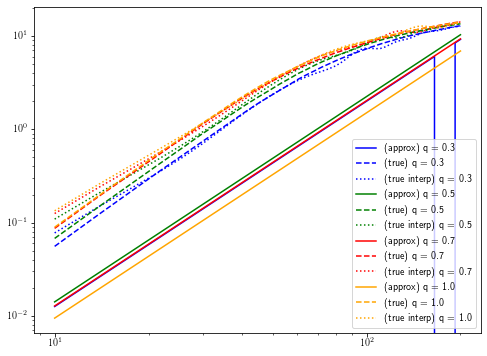

In [9]:
#Build interpolation function for VT
get_VT_true_interp = interpolate.RectBivariateSpline(m_list, m_list, VT_table)
print("VT interp = ", get_VT_true_interp.ev(7., 5.))
print("VT true = ", get_VT_true([7.], [5.]))


if (1):
    VT_true = get_VT_true([7.6], [2.4])
    print("VT_true = ", VT_true)
    
    #Test VT
    colors = ['blue','green','red','orange', 'purple']
    q_arr = np.array([0.3, 0.5, 0.7, 1.0])
    M_arr = np.linspace(10., 200., num = 50) #total mass
    fig, ax = pl.subplots(1,1, figsize = (8,6))
    for ii in range(0,len(q_arr)):
        m2 = M_arr/(1.+1./q_arr[ii])
        m1 = m2/q_arr[ii]
        #print("m2 = ", m2)
        #print("m1 = ", m1)
        mchirp, eta = m1m2_to_chirpeta(m1, m2)
        print("mchirp = ", mchirp[0])
        VT_true_toplot = get_VT_true(m1, m2)
        VT_true_toplot_interp = get_VT_true_interp.ev(m1,m2)
        ax.plot(M_arr, get_VT(m1, m2), label = '(approx) q = ' + str(q_arr[ii]), color = colors[ii])
        ax.plot(M_arr, VT_true_toplot, label = '(true) q = ' + str(q_arr[ii]), ls = 'dashed', color = colors[ii])
        ax.plot(M_arr, VT_true_toplot_interp, label = '(true interp) q = ' + str(q_arr[ii]), ls = 'dotted', color = colors[ii])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()


beta IMF fid smooth =  150.62258595171943


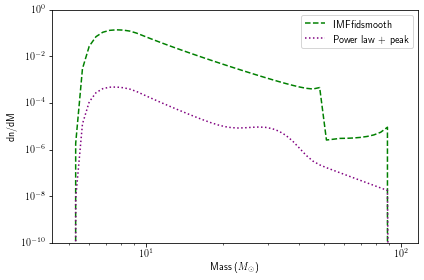

In [10]:
# Set initial parameter values and plot mass functions


#m1 and m2 values
m1 = np.exp(np.linspace(np.log(5.), np.log(100.), num = 50))
m2 = 6.


#M_max mass function
p0_Mmax = np.array([5.0, 60., 5.])

#IMF mass function
#        nn1 = params[0]
#        nnp = params[1]
#        M_max = params[2]
#        a = params[3]
#        b = params[4]
#        c = params[5]
#        d = params[6]
#        M_min = params[7]

#77777777777777777note that ones used to be 0.87

p0_IMF = np.array([1.0, np.log10(0.005), 60., 0.1, -3, 0.7, -2., 5.0])
p0_IMF2 = np.array([1.0, np.log10(0.05), 90., 0.9, -3, 0.7, -2., 5.0])

#IMF simple
p0_IMF_simple = np.array([1.0, np.log10(0.005), 46., 0.03, -2.4, -1.5, 5.0])

#IMF fid
if (exclude_190521):
    p0_IMF_fid = np.array([1.0, np.log10(0.005), 60., 0.2, -2.4, -1.5, 5.0])
else:
    p0_IMF_fid = np.array([1.0, np.log10(0.005), 80., 0.2, -2.4, -1.5, 5.0])

#Smoothed IMF fid
if (exclude_190521):
    p0_IMF_fidsmooth = np.array([1.0, np.log10(0.005), 50., 0.3, -2.4, -1.5, 5.0, 5.])
else:
    p0_IMF_fidsmooth = np.array([1.0, np.log10(0.005), 80., 0.1, -2.4, -1.5, 5.0, 5.])

    
#probs and n(M)
#p12_Mmax = get_mass_distrib(m1, m2, p0_Mmax, param_type = 'Mmax')
#p12_IMF = get_mass_distrib(m1, m2, p0_IMF, param_type = 'IMF')
#p12_IMF2 = get_mass_distrib(m1, m2, p0_IMF2, param_type = 'IMF')
#p12_IMFsimple = get_mass_distrib(m1, m2, p0_IMF_simple, param_type = 'IMFsimple')
#p12_IMFsimple2 = get_mass_distrib(m1, m2, p0_IMF_simple2, param_type = 'IMFsimple')
#p12_IMFfid = get_mass_distrib(m1, m2, p0_IMF_fid, param_type = 'IMFfid')
p12_IMFfidsmooth = get_mass_distrib(m1, m2, p0_IMF_fidsmooth, param_type = 'IMFfidsmooth')

#beta_Mmax = get_beta(p0_Mmax, param_type = 'Mmax')
#beta_IMF = get_beta(p0_IMF, param_type = 'IMF')
#beta_IMF_simple = get_beta(p0_IMF_simple, param_type = 'IMFsimple')
#beta_IMF_fid = get_beta(p0_IMF_fid, param_type = 'IMFfid')
beta_IMF_fidsmooth = get_beta(p0_IMF_fidsmooth, param_type = 'IMFfidsmooth')


#Broken power law and peak
#        nn1 = params[0]
#        alpha = params[1]
#        M_max = params[2]               
#        lambda_peak = params[3]
#        delta_m = params[4]
#        mu_m = params[5]
#        sigma_m = params[6]
#        M_min = params[7]
p0_plpeak = np.array([2.0, 3.0, 90., 0.1, 5., 30., 5., 5.0])
p12_plpeak = get_mass_distrib(m1, m2, p0_plpeak, param_type = 'plandpeak', verbose=False)
beta_plpeak = get_beta(p0_plpeak, param_type = 'plandpeak')


fig, ax = pl.subplots(1,1)
#ax.plot(m1, p12_Mmax, label = 'F\&H', color = 'orangered')
#ax.plot(m1, p12_IMF, label = 'IMF', color = 'dodgerblue', ls = 'solid')
#ax.plot(m1, p12_IMF2, label = 'IMF2', color = 'green', ls = 'dashed')
#ax.plot(m1, p12_IMFsimple, label = 'IMFsimple', color = 'black', ls = 'solid')
#ax.plot(m1, p12_IMFfid, label = 'IMFfid', color = 'red', ls = 'dashed')
ax.plot(m1, p12_IMFfidsmooth, label = 'IMFfidsmooth', color = 'green', ls = 'dashed')
#ax.plot(m1, p12_IMFsimple2, label = 'IMFsimple2', color = 'red', ls = 'dashed')
ax.plot(m1, p12_plpeak, label = 'Power law + peak', color = 'purple', ls = 'dotted')
ax.set_xlabel('Mass ($M_{\odot}$)')
ax.set_ylabel('dn/dM')
ax.set_xscale('log')
ax.set_ylim((1.0e-10, 1.0e0))
ax.legend()
ax.set_yscale('log')
fig.tight_layout()
#fig.savefig('dndM_compare.pdf')

#print("beta Mmax = ", beta_Mmax)
#print("beta IMF = ", beta_IMF)
#print("beta IMF simple = ", beta_IMF_simple)
#print("beta IMF fid = ", beta_IMF_fid)
print("beta IMF fid smooth = ", beta_IMF_fidsmooth)


In [11]:
#Test consistency of parameter to dict conversions

test = p0_Mmax - param_dict_to_vec(get_param_dict(p0_Mmax, param_type = 'Mmax'), param_type = 'Mmax')
print(test)

test = p0_IMF - param_dict_to_vec(get_param_dict(p0_IMF, param_type = 'IMF'), param_type = 'IMF')
print(test)

test = p0_IMF_simple - param_dict_to_vec(get_param_dict(p0_IMF_simple, param_type = 'IMFsimple'), param_type = 'IMFsimple')
print(test)

test = p0_IMF_fid - param_dict_to_vec(get_param_dict(p0_IMF_fid, param_type = 'IMFfid'), param_type = 'IMFfid')
print(test)

test = p0_IMF_fidsmooth - param_dict_to_vec(get_param_dict(p0_IMF_fidsmooth, param_type = 'IMFfidsmooth'), param_type = 'IMFfidsmooth')
print(test)


test = p0_plpeak - param_dict_to_vec(get_param_dict(p0_plpeak, param_type = 'plandpeak'), param_type = 'plandpeak')
print(test)


[0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
#Test m1 m2 samples
if (0):
    if (data_type == 'LIGOchains' or data_type == 'LIGOchains2'):
        #alpha = params[0]
        #M_max = params[1]
        #M_min = params[2]
        p0 = np.array([5.0, 60., 5.])
        if (0):
            m12_samples = get_m12_samps(bh_data[1], 10000)
        if (1):
            m12_samples = bh_data[0]['m12_samples']

        lnlike = data_likelihood(p0, m12_samples, param_type = 'Mmax')
        post = get_lnposterior(p0, bh_data, param_type = 'Mmax', verbose = True)
        #print("mean m1 m2 = ", np.mean(m12_samples, axis = 0))
        #print("std m1 m2 = ", np.std(m12_samples, axis = 0))
        print("lnlike1 = ", lnlike)
        print("post1 = ", post)
        print("******")
        p0 = np.array([2.0, 60., 5.])
        lnlike = data_likelihood(p0, m12_samples, param_type = 'Mmax')
        post = get_lnposterior(p0, bh_data, param_type = 'Mmax', verbose = True)
        print("lnlike2 = ", lnlike)
        print("post2 = ", post)

        #fig,ax = pl.subplots(1,1)
        #ax.plot(m12_samples[:,0], m12_samples[:,1], 'b,')

In [13]:
# TEST LIKELIHOODS

# IMF
#        n1 = params[0]
#        np = params[1]
#        MBHMG = params[2]
#        a = params[3]
#        b = params[4]
#        c = params[5]
#        d = params[6]
#        M_min = params[7]

#NOTES:
#-there are some events for which minimum m1 sample is like 43.5.  So as soon as M_BHMG goes below this, these events
# shouldn't be allowed, which means posterior goes to zero
#-for some reason, wants M_BHMG very close to this, with dndM getting very large near this mass
#-FOR SOME FUCKING REASON, posterior is peaking in weird way at M_BHMG near to maximum m1
#weight is diverging near M_BHMG
#-this happens because for some parameter choices, the n(M) is very strongly peaked at near mass gap,
#meaning that single samples from m1, m2 posterior can have a huge impact, which completely fucks up sampling
#- FOR SOME REASON IMFSIMPLE wants large d 
#-FOR SOME REASON LIGO PREFERS high M_max
#-double check event selection - https://arxiv.org/pdf/2010.14533.pdf
#-why does broken power law prefer lambda ~ 1, when not the case for LIGO analysis
#currently running evidence with (1) adjusted prior, (2) new functional form with a^2, (3) badlike instead of -1e40.  If none of that works, try reverting to old noise curve
#(1) maybe issue is that i got rid of those 0.99, (2) try fixing a few parms

#MMax
if (0):
    p0_Mmax = np.array([5.0, 60., 1, 5.])
    beta_Mmax = get_beta(p0_Mmax, param_type = 'Mmax')
    like_Mmax, weights_Mmax = data_likelihood(p0_Mmax, m12_samples, param_type = 'Mmax', return_weights = True)
    print("getting mmax posterior")
    post_Mmax = get_lnposterior(p0_Mmax, bh_data, param_type = 'Mmax')
    print("beta Mmax =", beta_IMF)
    print("lnlike Mmax = ", np.log(like_Mmax))
    print("post Mmax = ", post_Mmax)

if (0):
    for ii in range(0,1):
        m12_samples = bh_data[ii]['m12_samples']

        #new version that works with priors
        #p0_IMF = np.array([0.87, 0.0, 60., 0.2, -4.97, 0.05, 0.5, 2.0])
        #p0_IMF = np.array([0.87, 0.0, 39, 0.1, -3, 0.05, 0.5, 2.0])
        #funky version that has weird behavior with M_BHMG
        #p0_IMF = np.array([0.87, 0.0, 45., 0.2, -3, 3.0, 0.5, 2.0])
        #p0_IMF_1 = np.array([0.87, 0.0, np.max(bh_data[0]['m12_samples'][1,:]), 0.2, -3, 3.0, 0.5, 2.0])
        #p0_IMF_1 = np.array([0.87, 0.0, np.max(bh_data[0]['m12_samples'][1,:]), 0.1, -3, 0.05, 0.5, 2.0])
        #p0_IMF_1 = np.copy(p0_IMF)
        #p0_IMF_1[2] = 39
        #beta0 = get_beta(p0_IMF, param_type = 'IMF')
        #beta1 = get_beta(p0_IMF_1, param_type = 'IMF')
        #beta_simple = get_beta(p0_IMF_simple, param_type = 'IMFsimple')
        #print("beta simple = ", beta_simple)
        #beta_fid = get_beta(p0_IMF_fid, param_type = 'IMFfid')
        #print("beta fid = ", beta_fid)

        beta_fidsmooth = get_beta(p0_IMF_fidsmooth, param_type = 'IMFfidsmooth')
        print("beta fid smooth = ", beta_fidsmooth)

        
        #like_IMF, weights_IMF = data_likelihood(p0_IMF, bh_data[0]['m12_samples'], param_type = 'IMF', return_weights = True)
        #like_IMF_1, weights_IMF_1 = data_likelihood(p0_IMF_1, m12_samples, param_type = 'IMF', return_weights = True)

        #like_IMF_simple, weights_IMF_simple = data_likelihood(p0_IMF_simple, m12_samples, param_type = 'IMFsimple', return_weights = True)
        #like_IMF_fid, weights_IMF_fid = data_likelihood(p0_IMF_fid, m12_samples, param_type = 'IMFfid', return_weights = True)
        like_IMF_fidsmooth, weights_IMF_fidsmooth = data_likelihood(p0_IMF_fidsmooth, m12_samples, param_type = 'IMFfidsmooth', return_weights = True)
        #print("getting IMF posterior")
        #post_IMF = get_lnposterior(p0_IMF, bh_data, param_type = 'IMF')
        #print("beta IMF = ", beta0)
        #print("lnlike IMF = ", np.log(like_IMF))
        #print("lnlike IMF 1 = ", np.log(like_IMF_1))
        #print("lnlike IMF simple = ", np.log(like_IMF_simple))
        #print("lnlike IMF fid = ", np.log(like_IMF_fid))
        print("lnlike IMF fid smooth= ", np.log(like_IMF_fidsmooth))
        #print("post IMF = ", post_IMF)
        #print("sum0 = ", np.sum(weights_IMF/beta0))
        #print("sum1 = ", np.sum(weights_IMF_1/beta1))
        #print("mean IMF weights/beta = ", np.log(np.mean(weights_IMF_simple/beta_simple)))
        #print("sum IMF weights/beta = ", (np.sum(weights_IMF_simple/beta_simple)))

        fig, ax = pl.subplots(1,1)
        ax.plot(m12_samples[:,0], weights_IMF_fidsmooth/beta_simple, 'b,')
        #ax.plot(m12_samples[:,1], weights_IMF_simple/beta1, 'r,')
        ax.set_yscale('log')
        #ax.set_ylim((0.0,0.01))
    
#test posteriors
if (1):
    #post_IMF = get_lnposterior(p0_IMF, bh_data, \
    #                              param_type = 'IMF')
    #post_IMF2 = get_lnposterior(p0_IMF2, bh_data, \
    #                              param_type = 'IMF')
    
    #post_IMFsimple = get_lnposterior(p0_IMF_simple, bh_data, \
    #                              param_type = 'IMFsimple', verbose = True)
    
    #post_IMFfid = get_lnposterior(p0_IMF_fid, bh_data, \
    #                              param_type = 'IMFfid', verbose = True)

    post_IMFfidsmooth = get_lnposterior(p0_IMF_fidsmooth, bh_data, \
                                  param_type = 'IMFfidsmooth', verbose = True)
    
    
    #post_IMFsimple2 = get_lnposterior(p0_IMF_simple2, bh_data, \
    #                              param_type = 'IMFsimple')
    #print("post IMF = ", post_IMF)
    #print("post IMF2 = ", post_IMF2)
    #print("post IMFsimple = ", post_IMFsimple)
    #print("post IMFfid = ", post_IMFfid)
    print("post IMFfidsmooth = ", post_IMFfidsmooth)
    #print("post IMFsimple2 = ", post_IMFsimple2)
    
    #beta0 = get_beta(p0_bplpeak, param_type = 'plandpeak')
    #like_blpeak, weights_blpeak = data_likelihood(p0_bplpeak, m12_samples,\
    #                                        param_type = 'plandpeak', \
    #                                        return_weights = True)
    #print("getting pl + peak posterior")
    #post_blpeak = get_lnposterior(p0_bplpeak, bh_data, \
    #                              param_type = 'plandpeak')
    #print("blpeak posterior = ", post_blpeak)
        
    


lnlike_tot =  -339.61406736933304
lnprior =  0.0
post IMFfidsmooth =  -339.61406736933304


In [14]:
# Parameter choices and intial values
#bh_data = bh_data[0:4]


# IMF
#        n1 = params[0]
#        np = params[1]
#        MBHMG = params[2]
#        a = params[3]
#        b = params[4]
#        c = params[5]
#        d = params[6]
#        M_min = params[7]

#IMF
if (run_type == 'IMF'):
    param_names = np.array(['n1','$n_p$','$M_{BHMG}$','a','b','c','d','M_min'])
    #rough estimate of variance for generating starting parameters
    if (1):
        fix_param_vals = np.copy(p0_IMF)
        param_sigma_est = np.array([0.1, 0.02, 3., 0.02, 0.02, 0.02, 0.05, 0.1])
    if (0):
        fix_param_vals = np.copy(p0_IMF)
        param_sigma_est = np.array([0.1, 0.1, 3., 0.02, 0.02, 0.02, 0.05, 0.1])
    if (0):
        fix_param_vals = np.array([0.87, 0.0, 60., 0.2, -4, 3.0, 0.5, 5.0])
        param_sigma_est = np.array([0.1, 0.1, 3., 0.04, 0.1, 0.1, 0.1, 0.1])
    print(fix_param_vals)   
    # no secondary pop
    if (0):
        free_indices = np.array([2,3,4,5])
    # with secondary pop
    if (1):
        free_indices = np.array([1,2,3,4,5,6])
#IMFsimple
if (run_type == 'IMFsimple' or run_type == 'IMFfid'):
    param_names = np.array(['n1','$n_p$','$M_{BHMG}$','a','b','d','M_min'])
    #rough estimate of variance for generating starting parameters
    param_sigma_est = np.array([0.1, 0.02, 3., 0.02, 0.02, 0.05, 0.1])
    if (run_type == 'IMFsimple'):
        fix_param_vals = np.copy(p0_IMF_simple)
    if (run_type == 'IMFfid'):
        fix_param_vals = np.copy(p0_IMF_fid)

    print(fix_param_vals)   
    free_indices = np.array([1,2,3,4,5])
    b_index = 3
    d_index = 4

if (run_type == 'IMFfidsmooth'):
    param_names = np.array(['n1','n_p','M_{BHMG}','a','b','d','M_min', 'delta_m'])
    #rough estimate of variance for generating starting parameters
    param_sigma_est = 0.1*np.array([0.1, 0.02, 3., 0.02, 0.02, 0.05, 0.1, 1.0])
    fix_param_vals = np.copy(p0_IMF_fidsmooth)
    
    #best fit 
    #fix_param_vals = np.array([ 0.87,  -2.13557402, 49.32027137,  0.0913476,  -2.43246378, -0.87816021, 5.0169778,   5.46327523])
    
    print(fix_param_vals)   
    free_indices = np.array([1,2,3,4,5,6,7])
    #b_index = 3
    #d_index = 4
    
    
#Power law and peak
#        params = np.array([param_dict['n1'], param_dict['alpha'], param_dict['M_max'], \
#                           param_dict['lambda_peak'], param_dict['delta_m'], param_dict['mu_m'],\
#                           param_dict['sigma_m'], param_dict['M_min']])
if (run_type == 'plandpeak'):
    param_names = np.array(['n1','$alpha$','$M_{BHMG}$','$lambda$','delta_m','mu_m','sigma_m','M_min'])
    #rough estimate of variance for generating starting parameters
    if (1):
        param_sigma_est = np.array([2.0, 0.1, 3., 0.02, 1.0, 5.0, 0.1, 0.1])
        fix_param_vals = np.copy(p0_plpeak)
        print(fix_param_vals)
    print(fix_param_vals)   
    free_indices = np.array([1,2,3,4,5,6,7]) #added mmin


[ 2.   3.  90.   0.1  5.  30.   5.   5. ]
[ 2.   3.  90.   0.1  5.  30.   5.   5. ]


In [15]:
# Set up prior transforms

ndim = len(free_indices)

def uniform_tf(u, min_val, max_val):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[min_val, max_val)`."""

    x = u * (max_val - min_val) + min_val

    return x

def ptform_uniform(u, min_vals, max_vals):
    prior_ret = [uniform_tf(u[ii], min_vals[ii], max_vals[ii]) for ii in range(0,len(u))]
    return prior_ret
    
def ptform_uniform_andbd(u, min_vals, max_vals, b_index, d_index):
    pt = ptform_uniform(u, min_vals, max_vals)
   
    #prior that d > b
    bb = uniform_tf(u[b_index], min_vals[b_index], max_vals[b_index])
    pt[d_index] = uniform_tf(u[d_index], bb, max_vals[d_index])

    return pt

    
prior_min_vals, prior_max_vals = get_minmax(param_type = run_type)
print("min vals = ", prior_min_vals[free_indices])
print("max vals = ", prior_max_vals[free_indices])

uu = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
print(ptform_uniform(uu, prior_min_vals[free_indices], prior_max_vals[free_indices]))
print(len(fix_param_vals[free_indices]))
print(len(prior_min_vals))
print(len(prior_max_vals))

#if (run_type == 'IMFfid' or run_type == 'IMFfidsmooth'):
#    print(ptform_uniform_andbd(uu, prior_min_vals[free_indices], prior_max_vals[free_indices], b_index, d_index))
#    print(ptform_uniform_andbd(uu, prior_min_vals[free_indices], prior_max_vals[free_indices], b_index, d_index))



min vals =  [-4.  30.   0.   0.  20.   0.4  0. ]
max vals =  [ 12. 100.   1.  10.  50.  10.  10.]
[4.0, 65.0, 0.5, 5.0, 35.0]
7
8
8


In [ ]:
#if (run_type == 'IMFfid' or run_type == 'IMFfidsmooth'):
#    nssampler = NestedSampler(sample_lnlikelihood, ptform_uniform, ndim, \
#        logl_args = [bh_data, fix_param_vals, free_indices, run_type], \
#        ptform_args = [prior_min_vals[free_indices], prior_max_vals[free_indices], b_index, d_index])
#if (run_type == 'plandpeak'):
#    nssampler = NestedSampler(sample_lnlikelihood, ptform_uniform, ndim, \
#        logl_args = [bh_data, fix_param_vals, free_indices, run_type], \
#        ptform_args = [prior_min_vals[free_indices], prior_max_vals[free_indices]])

nssampler = NestedSampler(sample_lnlikelihood, ptform_uniform, ndim, \
                          logl_args = [bh_data, fix_param_vals, free_indices, run_type], \
                          ptform_args = [prior_min_vals[free_indices], prior_max_vals[free_indices]])
                    #, nlive = 1000
#                    nlive=500,\
#                         first_update={'min_eff': 20.})
#Try: sample = 'rwalk'
#sample = 'slice', bound='cubes'

#dssampler = DynamicNestedSampler(sample_lnlikelihood, ptform_uniform, ndim, \
#                          logl_args = [bh_data, fix_param_vals, free_indices, run_type], \
#                          ptform_args = [prior_min_vals[free_indices], prior_max_vals[free_indices]])


In [ ]:
nssampler.run_nested(dlogz = 1.0)

In [53]:
#save results
res = nssampler.results
save_dir = './nested_samples/'
filename =  'dynest_res_' + get_file_prefix(run_name, run_type = run_type, \
                                             secondary_type = secondary_type, \
                                             M_max_tot_choice = M_max_tot_choice, \
                                             exclude_190521 = exclude_190521, fudge_type = fudge_type) + '.pk'
pk.dump(res, open(save_dir + filename, 'wb'))


In [181]:
nssampler.results.summary()

Summary
nlive: 1000
niter: 7670
ncall: 52823
eff(%): 16.413
logz: -350.135 +/-  0.104


In [515]:

All events (including GW190521)
    
Summary - IMFfid with conditional prior
=======
nlive: 500
niter: 3230
ncall: 24875
eff(%): 14.995
logz: -321.512 +/-    nan
    
    
    
Summary - power law and peak
=======
nlive: 500
niter: 5598
ncall: 29786
eff(%): 20.473
logz: -312.980 +/-    nan
    
    
    
    
Excluding GW190521


Summary  - power law and peak
=======
nlive: 500
niter: 3988
ncall: 25568
eff(%): 17.553
logz: -292.637 +/-    nan

    
Summary - IMF fid
=======
nlive: 500
niter: 2674
ncall: 20977
eff(%): 15.131
logz: -293.971 +/-    nan
    
    
    
---------------------------------------------------------------------
With smoothing in p12, and redefined lambda 

All events (including GW190521)
    
Summary - power law and peak
=======
nlive: 500
niter: 4635
ncall: 29410
eff(%): 17.460
logz: -314.169 +/-    nan

    
    
Summary - IMFsmooth -but not varying deltam
=======
nlive: 500
niter: 3194
ncall: 23022
eff(%): 16.046
logz: -318.172 +/-    nan
    
    
Excluding GW190521

Summary - pl and peak
=======
nlive: 500
niter: 3942
ncall: 25438
eff(%): 17.462
logz: -290.916 +/-    nan

Summary - IMFsmooth -but not varying deltam (and varying Mmin)
=======
nlive: 500
niter: 2911
ncall: 21250
eff(%): 16.052
logz: -291.634 +/-    nan

    
Summary - IMFsmooth with physical secondary population -but not varying deltam (and varying Mmin)
=======
nlive: 500
niter: 2950
ncall: 22518
eff(%): 15.321
logz: -291.818 +/-    nan   

    
    
    
----WITH DELTAM and M_MIN free -----------------


Summary -  IMFsmooth with physical secondary population, no GW190521
=======
nlive: 500
niter: 9381
ncall: 42272
eff(%): 23.375
logz: -282.186 +/-    nan
    
    
    
------WITH DELTAM and MMIN FREE FIXED SMOOTHING IN CONDITIONAL -------

Summary -  IMFsmooth with physical secondary population, no GW190521
=======
nlive: 500
niter: 3205
ncall: 23257
eff(%): 15.931
logz: -294.656 +/-    nan

    
Summary - PL+ peak
=======
nlive: 500
niter: 4900
ncall: 32683
eff(%): 16.522
logz: -292.139 +/-    nan

    
    
-----------------------------------------------------------------------

Secondary population model with delta_m, and no conditional prior

IMF fid old a, fudge factor = 0.99

Summary
=======
nlive: 500
niter: 3015
ncall: 22275
eff(%): 15.780
logz: -347.667 +/-  0.162


IMFfid a-reparam, fudge factor = 0.99

Summary
=======
nlive: 500
niter: 3136
ncall: 23254
eff(%): 15.636
logz: -348.273 +/-  0.169


power law and peak

Summary
=======
nlive: 500
niter: 4626
ncall: 28972
eff(%): 17.693
logz: -348.017 +/- 

    
-------------------------------------------------------------

Secondary population model with delta_m, epsilon flattening

Summary
=======
nlive: 500
niter: 3066
ncall: 23277
eff(%): 15.320
logz: -349.113 +/-  0.163

    
PL+peak

Summary
=======
nlive: 500
niter: 4606
ncall: 29241
eff(%): 17.462
logz: -348.104 +/-  0.213


---------------------HI RES---------------

Final IMF smooth model exclude GW190521

Summary
=======
nlive: 500
niter: 3383
ncall: 24448
eff(%): 15.883
logz: -348.494 +/-  0.150
    
Final IMF smooth model with GW190521
    
Summary
=======
nlive: 800
niter: 6134
ncall: 43389
eff(%): 15.981
logz: -376.013 +/-  0.133
    

PL+peak exclude GW19052


Summary
=======
nlive: 500
niter: 5173
ncall: 31171
eff(%): 18.200
logz: -347.482 +/-  0.197
    
    
PL+peak wtih GW190521

Summary
=======
nlive: 800
niter: 9222
ncall: 54986
eff(%): 18.226
logz: -371.652 +/-  0.169

    

    

SyntaxError: invalid syntax (<ipython-input-515-d98ce6dc37ea>, line 2)

In [3]:
print(np.log10(np.exp(-347.482-(-348.494 ))))

print(np.log10(np.exp(-371.652 - (-376.013))))



0.43950601568609104
1.8939582355800768


[0.13577941 0.12527336 0.12007797 ... 0.12709267 0.12915308 0.13271392]


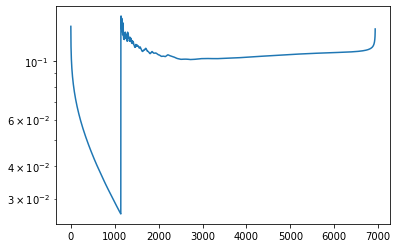

In [156]:
fig, ax = pl.subplots(1,1)
ax.plot(nssampler.results.logzerr)
ax.set_yscale('log')

print(nssampler.results.logzerr)


In [157]:
ndim

7

         nlive: 800
         niter: 6134
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 15.98100901150061
       samples: array([[-3.84019545e+00,  5.46221134e+01,  1.47155884e-01, ...,
        -3.20101175e+00,  4.94973291e+00,  8.68499987e+00],
       [-1.44816457e+00,  3.78805952e+01,  7.36467810e-02, ...,
        -4.45705664e+00,  1.08787574e+00,  4.07438133e+00],
       [ 8.62922671e-01,  4.92946052e+01,  4.54121953e-01, ...,
        -1.84453176e+00,  2.96644993e+00,  1.54455721e+00],
       ...,
       [-3.31917272e+00,  7.48527655e+01,  2.70247241e-02, ...,
        -1.03320773e+00,  3.17516723e+00,  6.84050149e+00],
       [-3.67052170e+00,  7.39017043e+01,  3.04865165e-02, ...,
        -2.27942836e+00,  3.59260193e+00,  6.19290715e+00],
       [-3.72102678e+00,  7.59895295e+01,  1.20006216e-02, ...,
        -4.91958109e+00,  3.04499191e+00,  6.49104918e+00]])
    samples_id: array([  1,   1,   1, ..., 685, 622, 707])
    samples_it: array([   0,    1,    2, ..., 

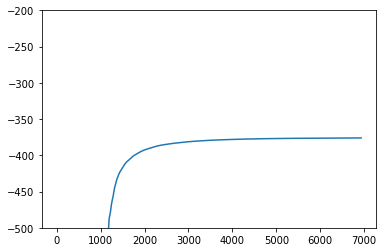

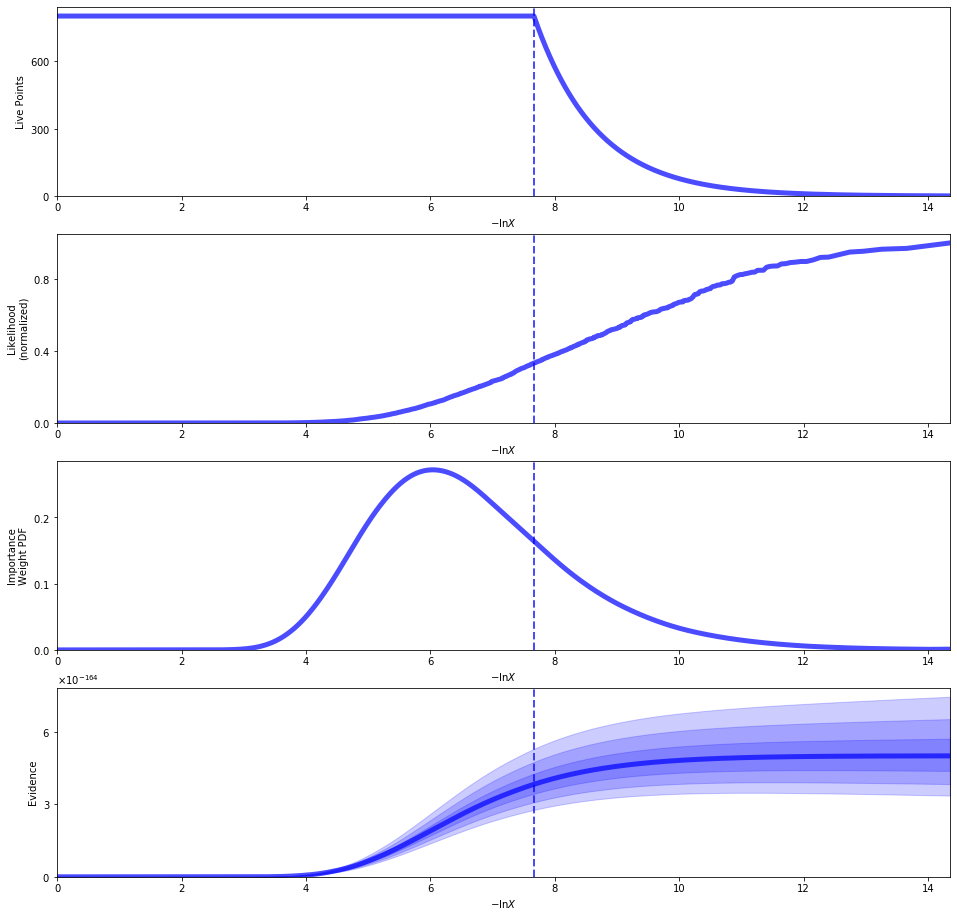

In [158]:
res = nssampler.results
print(res)

print(nssampler.results.samples_it.shape)
fig, ax =pl.subplots(1,1)
ax.plot(nssampler.results.logz)
ax.set_ylim((-500, -200))
fig, axes = dyplot.runplot(res)  # summary (run) plot

cornerdyn_aaa_runtypeIMFfidsmooth_secondaryphysical_mmax0_exclude190521False_epsilontypesharp.pdf


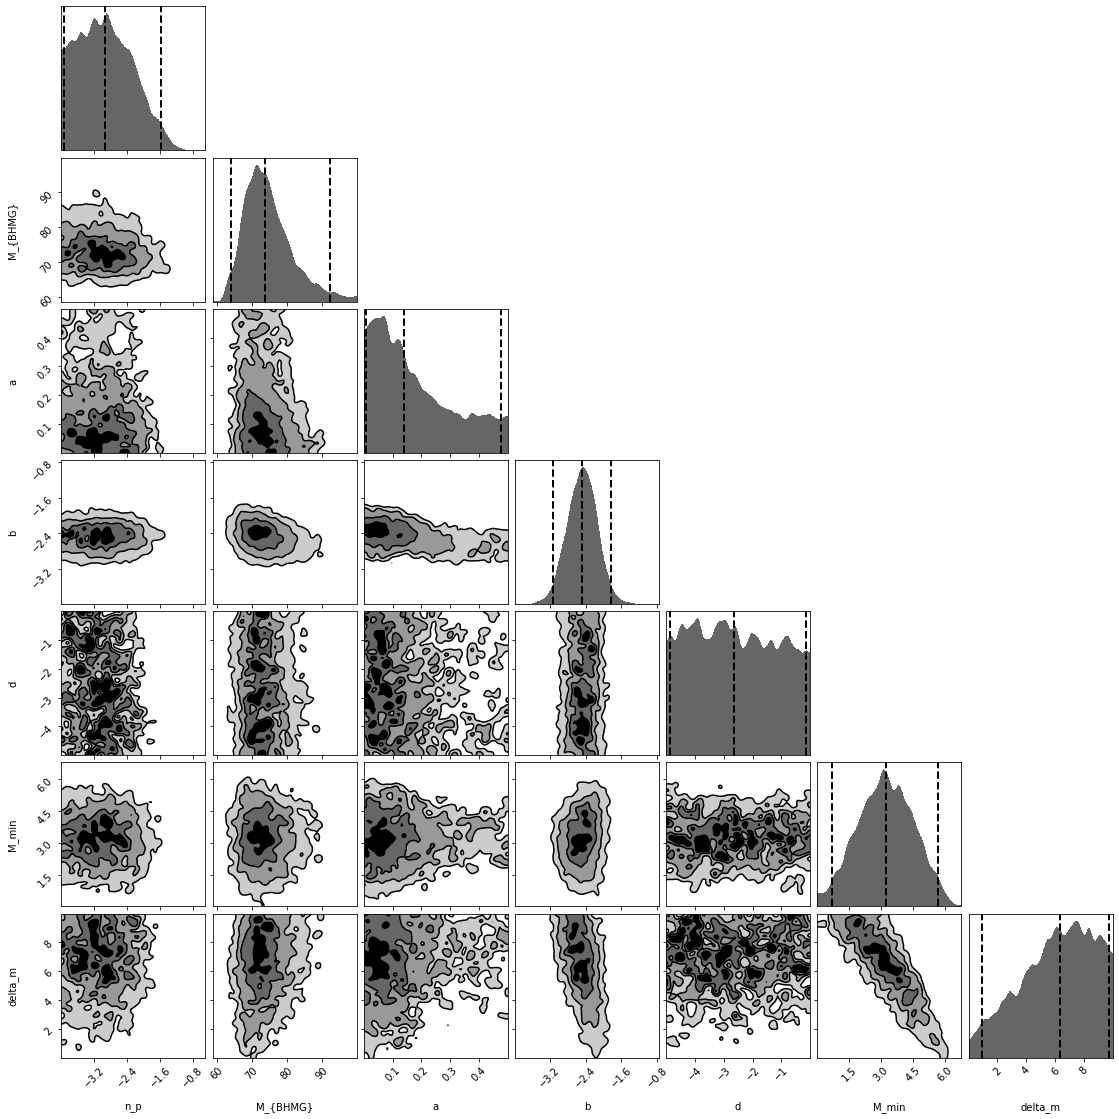

In [159]:
#Parameter corner plot from nested sampling run

output_dir = './corner_plots/'
output_filename = 'cornerdyn_' + get_file_prefix(run_name, run_type = run_type, secondary_type = secondary_type, M_max_tot_choice = M_max_tot_choice, exclude_190521 = exclude_190521, fudge_type = fudge_type) + '.pdf'
print(output_filename)

fg, ax = dyplot.cornerplot(res, labels = param_names[free_indices])
fg.savefig(output_dir + output_filename)

In [60]:
#Parameter corner plot from nested sampling run
from getdist import plots, MCSamples

plot_run_type = 'plandpeak'
plot_exclude_GW190521 = False
dyn_filename = './nested_samples/' + 'dynest_res_' + get_file_prefix(run_name, run_type = plot_run_type, \
                                             secondary_type = secondary_type, \
                                             M_max_tot_choice = M_max_tot_choice, \
                                             exclude_190521 = plot_exclude_GW190521, fudge_type = fudge_type) + '.pk'
res_with190521 = pk.load(open(dyn_filename, 'rb'))
plot_exclude_GW190521 = True
dyn_filename = './nested_samples/' + 'dynest_res_' + get_file_prefix(run_name, run_type = plot_run_type, \
                                             secondary_type = secondary_type, \
                                             M_max_tot_choice = M_max_tot_choice, \
                                             exclude_190521 = plot_exclude_GW190521, fudge_type = fudge_type) + '.pk'
res_no190521 = pk.load(open(dyn_filename, 'rb'))


if (plot_run_type == 'IMFfidsmooth'):
    param_labels_starr = np.array(['n_1','\\log_{10} \\lambda','M_{\\mathrm{BHMG}}','a','b','d','M_{\\mathrm{min}}', '\\delta_m'])
    param_names_starr = np.array(['n1','lambda','MBHMG','a','b','d','Mmin', 'deltam'])
    free_indices = np.array([1,2,3,4,5,6,7])
if (plot_run_type == 'plandpeak'):
    param_labels_starr = np.array(['n_1','\\alpha','M_{\\mathrm{max}}','\\lambda_{\mathrm{peak}}','\\delta_m','\\mu_m','\\sigma_m','M_{\\mathrm{min}}'])
    param_names_starr = np.array(['n1','alpha','Mmax','lambdapeak','deltam','mum','sigmam','Mmin'])
    free_indices = np.array([1,2,3,4,5,6,7]) #added mmin
    

#numbers for 1d histograms
if (0):
    param_index = 4
    weights = np.exp(res.logwt - res.logz[-1])
    #weights = np.exp(res.logwt)
    weights = weights/np.sum(weights)
    hist, bin_edges = np.histogram(res.samples[:,param_index], weights = weights, bins = 40, range = (20, 50), density = True)
    bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])
    output_hist = np.vstack((bin_cents, hist))

    
    #M_max
    #mmaxhist_filename = 'Mmaxhist_' + get_file_prefix(run_name, run_type = plot_run_type, secondary_type = secondary_type, M_max_tot_choice = M_max_tot_choice, exclude_190521 = plot_exclude_GW190521, fudge_type = fudge_type) + '.dat'
    
    #mu_m
    mmaxhist_filename = 'mum_' + get_file_prefix(run_name, run_type = plot_run_type, secondary_type = secondary_type, M_max_tot_choice = M_max_tot_choice, exclude_190521 = plot_exclude_GW190521, fudge_type = fudge_type) + '.dat'
    print(output_hist.shape)
    mmaxhist_dir = './M_max_hists/'
    #np.savetxt(mmaxhist_dir + mmaxhist_filename, np.transpose(output_hist), header = '; M_max    P(M_max)')

    #print(res)

    fig, ax = pl.subplots(1,1)
    bin_cent = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.plot(bin_cent, hist)

    
    
output_dir = './corner_plots/'
output_filename = 'corner_getdist_' + get_file_prefix(run_name, run_type = plot_run_type, secondary_type = secondary_type, M_max_tot_choice = M_max_tot_choice, fudge_type = fudge_type) + '.pdf'
print(output_filename)
    
#fg, ax = dyplot.cornerplot(res, labels = param_name_starr[free_indices])
#fg.savefig(output_dir + output_filename)

def get_mc_samples(res):
    weights = np.exp(res.logwt - res.logz[-1])
    min_vals, max_vals = get_minmax(param_type = plot_run_type)
    ranges = {}
    for ii in range(0,len(free_indices)):
        ranges[param_names_starr[free_indices[ii]]] = [min_vals[free_indices[ii]], max_vals[free_indices[ii]]]
        
    print(ranges)
       
    if (plot_run_type == 'IMFfidsmooth'):
        return MCSamples(samples=res.samples, weights = weights, names = param_names_starr[free_indices], labels = param_labels_starr[free_indices], ranges = ranges)
    if (plot_run_type == 'plandpeak'):
        reorder = np.array([0,1,2,4,5,6,3])
        #temp1 = res.samples[:,reorder],
        #temp2 = (param_names_starr[free_indices])[reorder]
        #temp3 = (param_labels_starr[free_indices])[reorder]
        #pdb.set_trace()
        #temp4 = ranges[reorder]
        return MCSamples(samples=res.samples[:,reorder], weights = weights, names = (param_names_starr[free_indices])[reorder], labels = (param_labels_starr[free_indices])[reorder], ranges = ranges)

    
samples_with190521 = get_mc_samples(res_with190521)
samples_no190521 = get_mc_samples(res_no190521)

g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
g.settings.axes_fontsize=18
g.settings.legend_fontsize = 26
g.settings.axes_labelsize = 22
g.contours = [0.90, 0.95, 0.99]
samples_with190521.updateSettings({'contours':[0.90,0.95,0.99]})
samples_no190521.updateSettings({'contours':[0.90,0.95,0.99]})
g.triangle_plot([samples_with190521, samples_no190521], filled=True, legend_labels=[r'${\rm With\,\,GW190521}$', r'${\rm No\,\,GW190521}$'], \
            line_args=[{'lw':2, 'ls':'--', 'color':'blue'}, {'lw':2, 'color':'green'}], 
            contour_colors=['blue','green'], legend_loc = 'upper right', label_order = -1)#(, title_limit = 1)
#g.export(output_dir + output_filename)

#90% intervals
#from scipy.stats import norm
#pp = 0.68
#z_for_90 = norm.ppf(0.5+0.5*pp)
print("no GW190521")
print(samples_no190521.getTable(limit=1).tableTex())
print("with GW190521")
print(samples_with190521.getTable(limit=1).tableTex())

FileNotFoundError: [Errno 2] No such file or directory: './nested_samples/dynest_res_GWTC1_runtypeplandpeak_secondaryphysical_mmax0_exclude190521False_epsilontypesharp.pk'

corner_getdist_O3vsO1_IMFfidsmooth.pdf
{'lambda': [-4.0, 1.0], 'MBHMG': [30.0, 100.0], 'a': [0.0, 0.5], 'b': [-4.0, 0.0], 'd': [-5.0, 0.0], 'Mmin': [0.0, 10.0], 'deltam': [0.0, 10.0]}
Removed no burn in
{'lambda': [-4.0, 1.0], 'MBHMG': [30.0, 100.0], 'a': [0.0, 0.5], 'b': [-4.0, 0.0], 'd': [-5.0, 0.0], 'Mmin': [0.0, 10.0], 'deltam': [0.0, 10.0]}
Removed no burn in


O1
\begin{tabular} { l  c}

 Parameter &  90\% limits\\
\hline
{\boldmath$\log_{10} \lambda$} & $< -1.09                   $\\

{\boldmath$M_{\mathrm{BHMG}}$} & $45\pm 9                   $\\

{\boldmath$a              $} & ---                         \\

{\boldmath$b              $} & $-1.88\pm 0.86             $\\

{\boldmath$d              $} & ---                         \\

{\boldmath$M_{\mathrm{min}}$} & $4.2^{+3.1}_{-3.9}         $\\

{\boldmath$\delta_m       $} & ---                         \\
\hline
\end{tabular}
O3
\begin{tabular} { l  c}

 Parameter &  90\% limits\\
\hline
{\boldmath$\log_{10} \lambda$} & $< -1.54                   $\\

{\boldmath$M_{\mathrm{BHMG}}$} & $55.4\pm 5.3               $\\

{\boldmath$a              $} & ---                         \\

{\boldmath$b              $} & $-1.99\pm 0.42             $\\

{\boldmath$d              $} & ---                         \\

{\boldmath$M_{\mathrm{min}}$} & $3.3\pm 1.4                $\\

{\boldmath$\delta_m      

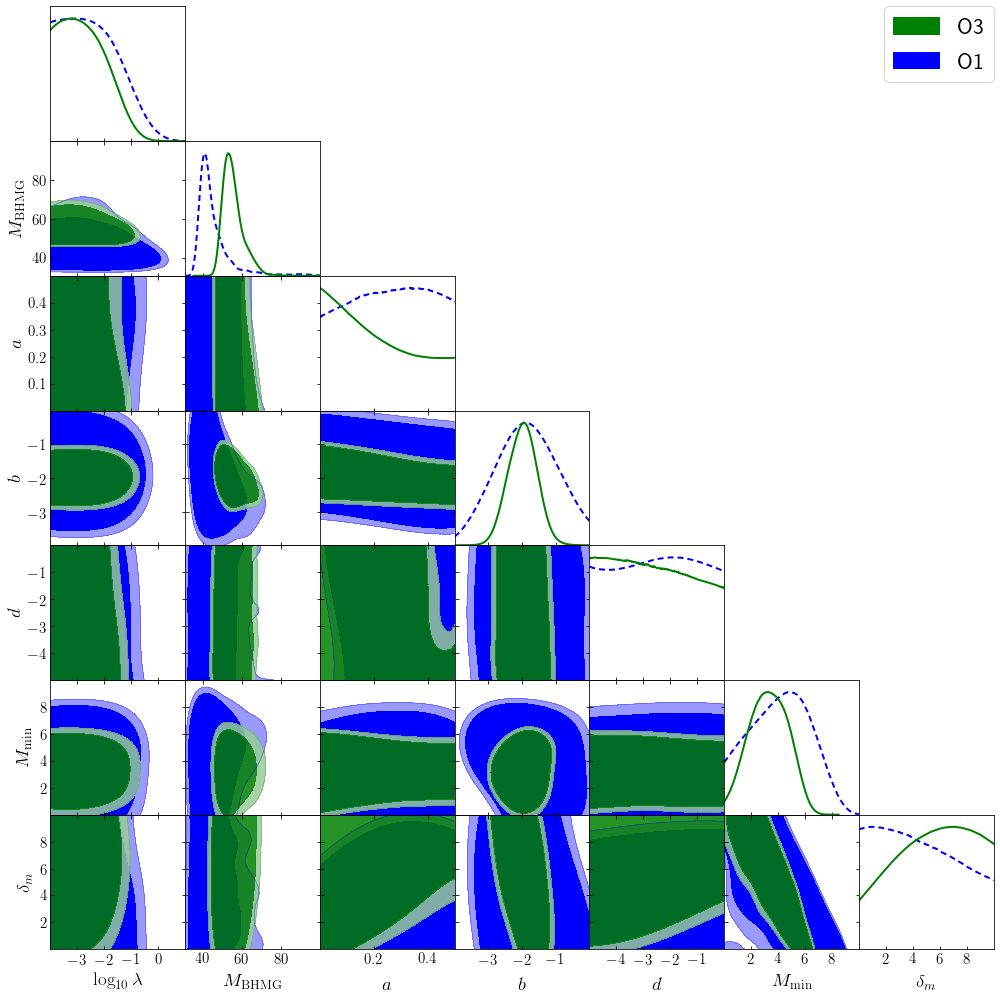

In [61]:
#Parameter corner plot from nested sampling run
from getdist import plots, MCSamples

plot_run_type = 'IMFfidsmooth'

dyn_dir = './nested_samples/'
if (plot_run_type == 'IMFfidsmooth'):
    O1_filename = 'dynest_res_GWTC1_runtypeIMFfidsmooth_secondaryphysical_mmax0_exclude190521True_epsilontypesharp.pk'
    O3_filename = 'dynest_res_aaa_runtypeIMFfidsmooth_secondaryphysical_mmax0_exclude190521True_epsilontypesharp.pk'
if (plot_run_type == 'plandpeak'):
    O1_filename = 'dynest_res_GWTC1_runtypeplandpeak_secondaryphysical_mmax0_exclude190521True_epsilontypesharp.pk'
    O3_filename = 'dynest_res_aaa_runtypeplandpeak_secondaryphysical_mmax0_exclude190521True_epsilontypesharp.pk'

res_O1 = pk.load(open(dyn_dir + O1_filename, 'rb'))
res_O3 = pk.load(open(dyn_dir + O3_filename, 'rb'))


if (plot_run_type == 'IMFfidsmooth'):
    param_labels_starr = np.array(['n_1','\\log_{10} \\lambda','M_{\\mathrm{BHMG}}','a','b','d','M_{\\mathrm{min}}', '\\delta_m'])
    param_names_starr = np.array(['n1','lambda','MBHMG','a','b','d','Mmin', 'deltam'])
    free_indices = np.array([1,2,3,4,5,6,7])
if (plot_run_type == 'plandpeak'):
    param_labels_starr = np.array(['n_1','\\alpha','M_{\\mathrm{max}}','\\lambda_{\mathrm{peak}}','\\delta_m','\\mu_m','\\sigma_m','M_{\\mathrm{min}}'])
    param_names_starr = np.array(['n1','alpha','Mmax','lambdapeak','deltam','mum','sigmam','Mmin'])
    free_indices = np.array([1,2,3,4,5,6,7]) #added mmin
    

#numbers for 1d histograms
if (0):
    param_index = 4
    weights = np.exp(res.logwt - res.logz[-1])
    #weights = np.exp(res.logwt)
    weights = weights/np.sum(weights)
    hist, bin_edges = np.histogram(res.samples[:,param_index], weights = weights, bins = 40, range = (20, 50), density = True)
    bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])
    output_hist = np.vstack((bin_cents, hist))

    
    #M_max
    #mmaxhist_filename = 'Mmaxhist_' + get_file_prefix(run_name, run_type = plot_run_type, secondary_type = secondary_type, M_max_tot_choice = M_max_tot_choice, exclude_190521 = plot_exclude_GW190521, fudge_type = fudge_type) + '.dat'
    
    #mu_m
    mmaxhist_filename = 'mum_' + get_file_prefix(run_name, run_type = plot_run_type, secondary_type = secondary_type, M_max_tot_choice = M_max_tot_choice, exclude_190521 = plot_exclude_GW190521, fudge_type = fudge_type) + '.dat'
    print(output_hist.shape)
    mmaxhist_dir = './M_max_hists/'
    #np.savetxt(mmaxhist_dir + mmaxhist_filename, np.transpose(output_hist), header = '; M_max    P(M_max)')

    #print(res)

    fig, ax = pl.subplots(1,1)
    bin_cent = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.plot(bin_cent, hist)

    
    
output_dir = './corner_plots/'
output_filename = 'corner_getdist_O3vsO1_' + plot_run_type + '.pdf'
print(output_filename)
    
#fg, ax = dyplot.cornerplot(res, labels = param_name_starr[free_indices])
#fg.savefig(output_dir + output_filename)

def get_mc_samples(res):
    weights = np.exp(res.logwt - res.logz[-1])
    min_vals, max_vals = get_minmax(param_type = plot_run_type)
    ranges = {}
    for ii in range(0,len(free_indices)):
        ranges[param_names_starr[free_indices[ii]]] = [min_vals[free_indices[ii]], max_vals[free_indices[ii]]]
        
    print(ranges)
       
    if (plot_run_type == 'IMFfidsmooth'):
        return MCSamples(samples=res.samples, weights = weights, names = param_names_starr[free_indices], labels = param_labels_starr[free_indices], ranges = ranges)
    if (plot_run_type == 'plandpeak'):
        reorder = np.array([0,1,2,4,5,6,3])
        #temp1 = res.samples[:,reorder],
        #temp2 = (param_names_starr[free_indices])[reorder]
        #temp3 = (param_labels_starr[free_indices])[reorder]
        #pdb.set_trace()
        #temp4 = ranges[reorder]
        return MCSamples(samples=res.samples[:,reorder], weights = weights, names = (param_names_starr[free_indices])[reorder], labels = (param_labels_starr[free_indices])[reorder], ranges = ranges)

    
samples_O1 = get_mc_samples(res_O1)
samples_O3 = get_mc_samples(res_O3)

g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
g.settings.axes_fontsize=18
g.settings.legend_fontsize = 26
g.settings.axes_labelsize = 22
g.contours = [0.90, 0.95, 0.99]
samples_O1.updateSettings({'contours':[0.90,0.95,0.99]})
samples_O3.updateSettings({'contours':[0.90,0.95,0.99]})
g.triangle_plot([samples_O1, samples_O3], filled=True, legend_labels=[r'O1', r'O3'], \
            line_args=[{'lw':2, 'ls':'--', 'color':'blue'}, {'lw':2, 'color':'green'}], 
            contour_colors=['blue','green'], legend_loc = 'upper right', label_order = -1)#(, title_limit = 1)
g.export(output_dir + output_filename)

#90% intervals
#from scipy.stats import norm
#pp = 0.68
#z_for_90 = norm.ppf(0.5+0.5*pp)
print("O1")
print(samples_O1.getTable(limit=1).tableTex())
print("O3")
print(samples_O3.getTable(limit=1).tableTex())

In [521]:
print(samples_with190521.ranges)

     \log_{10} \lambda   -2.0000000E+00    0.0000000E+00
     M_{\mathrm{BHMG}}    3.0000000E+01    1.0000000E+02
                     a    0.0000000E+00    5.0000000E-01
                     b   -4.0000000E+00    0.0000000E+00
                     d   -5.0000000E+00    0.0000000E+00
      M_{\mathrm{min}}    0.0000000E+00    1.0000000E+01
              \delta_m    0.0000000E+00    1.0000000E+01



In [352]:
from scipy import stats

def get_surprise(mean1, mean2, cov1, cov2):
    #2 = new
    #1 = p
    dd = mean1.shape[0]
    invcov1 = np.linalg.inv(cov1)
    theta_diff = mean1-mean2
    term1 = 0.5*np.dot(theta_diff, np.dot(invcov1, theta_diff))
    term2 = 0.5*(np.sum(np.diag(np.dot(cov2, invcov1))) - dd - np.log(np.linalg.det(cov2)/np.linalg.det(cov1)))
    bigD = term1+term2
    meanbigD = -0.5*np.log(np.linalg.det(cov2)/np.linalg.det(cov1))
    print("bigD = ", bigD)
    print("meanbigD = ", meanbigD)
    bigS = bigD - meanbigD
    print("bigS = ", bigS)
    #trMat = np.dot(invcov2,)
    #vardD = 0.5*np.sum(np.diag(trMat))
    
def get_update_diff(mean1, mean12, cov1, cov12):
    print(mean12)
    print(np.sqrt(np.diag(cov12)))
    DeltaThetaU = mean1 - mean12
    CovDeltaThetaU = cov1 - cov12
    print("DeltaThetaU = ", DeltaThetaU)
    A = np.linalg.pinv(CovDeltaThetaU)
    print("eig = ", np.linalg.eig(CovDeltaThetaU))
    Q_UDM = np.dot(DeltaThetaU, np.dot(A, DeltaThetaU))
    print("Q_UDM = ", Q_UDM)
    dof = np.linalg.matrix_rank(CovDeltaThetaU)
    print("dof = ", dof)
    pte = 1 - stats.chi2.cdf(Q_UDM, dof)
    print("pte = ", pte)
    

from dynesty import utils as dyfunc

# Compute surprise

plot_run_type = 'plandpeak'

plot_exclude_GW190521 = True
dyn_filename = './nested_samples/' + 'dynest_res_' + get_file_prefix(run_name, run_type = plot_run_type, \
                                             secondary_type = secondary_type, \
                                             M_max_tot_choice = M_max_tot_choice, \
                                             exclude_190521 = plot_exclude_GW190521, fudge_type = fudge_type) + '.pk'
res_no19521 = pk.load(open(dyn_filename, 'rb'))

plot_exclude_GW190521 = False
dyn_filename = './nested_samples/' + 'dynest_res_' + get_file_prefix(run_name, run_type = plot_run_type, \
                                             secondary_type = secondary_type, \
                                             M_max_tot_choice = M_max_tot_choice, \
                                             exclude_190521 = plot_exclude_GW190521, fudge_type = fudge_type) + '.pk'
res_with19521 = pk.load(open(dyn_filename, 'rb'))




samples_no19521, weights_no19521 = res_no19521.samples, np.exp(res_no19521.logwt - res_no19521.logz[-1])
mean_no19521, cov_no19521 = dyfunc.mean_and_cov(samples_no19521, weights_no19521)

samples_with19521, weights_with19521 = res_with19521.samples, np.exp(res_with19521.logwt - res_with19521.logz[-1])
mean_with19521, cov_with19521 = dyfunc.mean_and_cov(samples_with19521, weights_with19521)

#get_surprise(mean_no19521, mean_with19521, cov_no19521, cov_with19521)
get_update_diff(mean_no19521, mean_with19521, cov_no19521, cov_with19521)


[ 2.72126246 84.80694742  0.11290238  3.7008423  33.97979842  4.69334351
  4.4031717 ]
[0.46811828 8.21862332 0.07737028 2.31615961 2.17229643 2.45893708
 1.10503756]
DeltaThetaU =  [ 3.62608890e-01 -1.32686433e+01 -5.45514191e-03 -5.15843580e-01
 -5.72041523e-01  1.30804293e+00  1.59857533e-01]
eig =  (array([ 6.57523219e+01,  2.96309761e+00,  1.46897462e+00, -1.17917517e+00,
       -1.96119663e-01, -1.16833435e-03,  4.10255965e-04]), array([[-3.89119295e-02, -3.93224335e-01, -5.24711970e-01,
         5.84295404e-03, -6.93386902e-01,  2.74490200e-01,
        -1.11235907e-01],
       [-9.98755142e-01,  6.58561522e-03,  4.65288035e-02,
         5.40037313e-03,  1.50539664e-02, -4.59007310e-03,
         1.73546723e-03],
       [-2.18207012e-04,  3.66400811e-03, -7.18408991e-04,
        -2.16039345e-02,  1.20552345e-02,  4.05119602e-01,
         9.13921255e-01],
       [ 4.61340268e-03,  9.36914287e-03,  4.21014611e-04,
         9.29179300e-01, -1.42922996e-01, -3.02029068e-01,
         1

In [160]:
print(param_names[free_indices])

['n_p' 'M_{BHMG}' 'a' 'b' 'd' 'M_min' 'delta_m']


In [16]:
# Initial parameter values for emcee

ndim = len(free_indices)
nwalkers = 64
#p0 = 1.0*np.random.rand(nwalkers, ndim) + np.tile(fix_param_vals[free_indices],(nwalkers,1))
p0 = np.zeros((nwalkers, ndim))
for ii in range(0,nwalkers):
    this_p0 = fix_param_vals[free_indices] + np.random.randn(ndim)*param_sigma_est[free_indices]
    p0[ii,:] = this_p0
    full_p0 = np.copy(fix_param_vals)
    full_p0[free_indices] = this_p0
    print("post = ", get_lnposterior(full_p0, bh_data, param_type = run_type, verbose = True))
    
print(p0.shape)

lnlike_tot =  -334.34696516515294
lnprior =  0.0
post =  -334.34696516515294
lnlike_tot =  -335.8681626846633
lnprior =  0.0
post =  -335.8681626846633
lnlike_tot =  -334.3739968556928
lnprior =  0.0
post =  -334.3739968556928
lnlike_tot =  -334.8454513812493
lnprior =  0.0
post =  -334.8454513812493
lnlike_tot =  -341.5802430006751
lnprior =  0.0
post =  -341.5802430006751
lnlike_tot =  -339.1703725660389
lnprior =  0.0
post =  -339.1703725660389
lnlike_tot =  -336.39619599861527
lnprior =  0.0
post =  -336.39619599861527
lnlike_tot =  -333.797575171732
lnprior =  0.0
post =  -333.797575171732
lnlike_tot =  -337.10739357316896
lnprior =  0.0
post =  -337.10739357316896
lnlike_tot =  -335.1000071484523
lnprior =  0.0
post =  -335.1000071484523
lnlike_tot =  -336.9653987139705
lnprior =  0.0
post =  -336.9653987139705
lnlike_tot =  -336.03803232512615
lnprior =  0.0
post =  -336.03803232512615
lnlike_tot =  -334.6671175508848
lnprior =  0.0
post =  -334.6671175508848
lnlike_tot =  -338.

In [503]:
#get best-fit parameters

def get_flattened_chain(chain, burnin):
    chain_b = chain[burnin:,:,:]
    dims = chain_b.shape
    output = chain_b.reshape((dims[0]*dims[1],dims[2]))
    return output

def get_flattened_lnprob(lnprob, burnin):
    lnprob_b = lnprob[burnin:,:]
    dims = lnprob_b.shape
    output = lnprob_b.reshape((dims[0]*dims[1]))
    return output


from scipy import optimize as op

min_vals, max_vals = get_minmax(run_type)
bound = op.Bounds(min_vals[free_indices], max_vals[free_indices])

chain = pk.load(open('./chains/emcee/chainz_aaa_runtypeIMFfidsmooth_secondaryphysical_mmax0_exclude190521True_epsilontypesharp_500_64_7.pk','rb'))
burnin = 100
plot_chain = get_flattened_chain(chain['chain'], burnin)
lnprob = get_flattened_lnprob(chain['lnprob'], burnin)
plot_fix_params = chain['args'][1]


bad = np.where(plot_fix_params != fix_param_vals)[0]
if (len(bad) > 0):
    print("BAD")

print("dims chain = ", plot_chain.shape)
print("dims lnprob = ", lnprob.shape)
best_index = np.argmax(lnprob)
best_params = plot_chain[best_index,:]
best_params_all = np.copy(plot_fix_params)
best_params_all[free_indices] = best_params

#start_params = fix_param_vals[free_indices]
start_params = np.copy(best_params)

#min_result = op.minimize(sample_neglnposterior, start_params, args = (bh_data, fix_param_vals, free_indices, run_type), method = 'Nelder-Mead', options= {'fatolnumber':0.01}) # --> -lnpost =  -342.6075683216337
#min_result =  op.minimize(sample_neglnposterior, start_params, bounds = bound, args = (bh_data, fix_param_vals, free_indices, run_type), method = 'Powell', options= {'ftol':0.01})
#hop_resutls = op.basinhopping(sample_neglnposterior, start_params, minimizer_kwargs = {'args':(bh_data, fix_param_vals, free_indices, run_type)})
#best_params = min_result.x

test = np.copy(best_params)
test[2] = 0.2
print(test)
sample_neglnposterior(test, bh_data, fix_param_vals, free_indices, run_type)

dims chain =  (25600, 7)
dims lnprob =  (25600,)
[-1.93527744 53.08083097  0.2        -1.43710394 -1.71201296  5.94345011
  0.49829846]
-lnpost =  -342.9008348235906


342.9008348235906

In [17]:
#restricting BH data
#bh_data_restricted = bh_data[0:4]

sampler = emcee.EnsembleSampler(nwalkers, ndim, sample_lnposterior, args=[bh_data, fix_param_vals, free_indices, run_type])
state = sampler.run_mcmc(p0, 400, progress = True)


  7%|▋         | 36/500 [28:20<6:04:38, 47.15s/it]/home/ebaxter/anaconda2/envs/mypython3/lib/python3.7/site-packages/ipykernel_launcher.py:515: RuntimeWarning: invalid value encountered in double_scalars
/home/ebaxter/anaconda2/envs/mypython3/lib/python3.7/site-packages/ipykernel_launcher.py:516: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [6:34:12<00:00, 47.31s/it]  


In [18]:
#Save chain
if (1):
    chain_dir = './chains/emcee/'
    chain_name = 'chainz_' + get_file_prefix(run_name, run_type = run_type, \
                                             secondary_type = secondary_type, \
                                             M_max_tot_choice = M_max_tot_choice, \
                                             exclude_190521 = exclude_190521, fudge_type = fudge_type) + '_' + str(sampler.get_chain().shape[0]) + '_' + \
                                            str(sampler.get_chain().shape[1]) + '_' + \
                                            str(sampler.get_chain().shape[2]) +'.pk'
    save_data = {'chain':sampler.get_chain(), 'args':[bh_data, fix_param_vals, free_indices, run_type],\
                'lnprob':sampler.get_log_prob(), 'blobs':sampler.get_blobs()}
    pk.dump(save_data, open(chain_dir + chain_name, 'wb'))

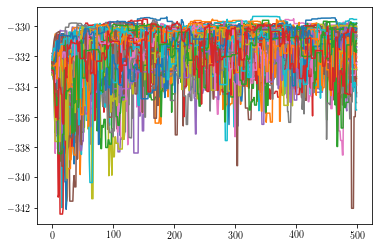

In [146]:
fig, ax = pl.subplots(1,1)
ax.plot(sampler.get_log_prob())

In [68]:
def get_flattened_chain(chain, burnin):
    chain_b = chain[burnin:,:,:]
    dims = chain_b.shape
    output = chain_b.reshape((dims[0]*dims[1],dims[2]))
    return output

def get_flattened_lnlike(lnlike, burnin):
    lnlike_b = lnlike[burnin:,:]
    dims = lnlike_b.shape
    output = lnlike_b.reshape((dims[0]*dims[1]))
    return output


(500, 64, 7)
(500, 64)


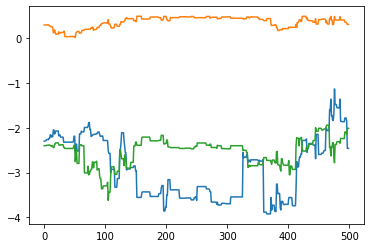

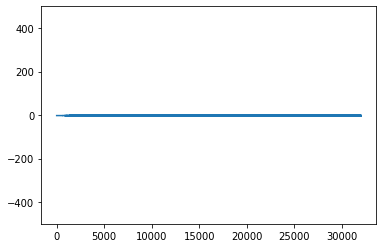

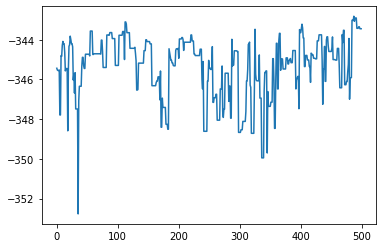

In [119]:
temp = sampler.get_chain(discard = 0)
print(temp.shape)

fig, ax = pl.subplots(1,1)
ax.plot(temp[:,0,0])
#ax.plot(temp[:,0,1])
ax.plot(temp[:,0,2])
ax.plot(temp[:,0,3])


lnprob = sampler.get_log_prob()
print(lnprob.shape)

tt = sampler.get_chain(discard = 0, flat = True)
fig, ax = pl.subplots(1,1)
ax.plot(tt[:,0])
ax.set_ylim((-500, 500))


fig, ax = pl.subplots(1,1)
ax.plot(lnprob[:,7])


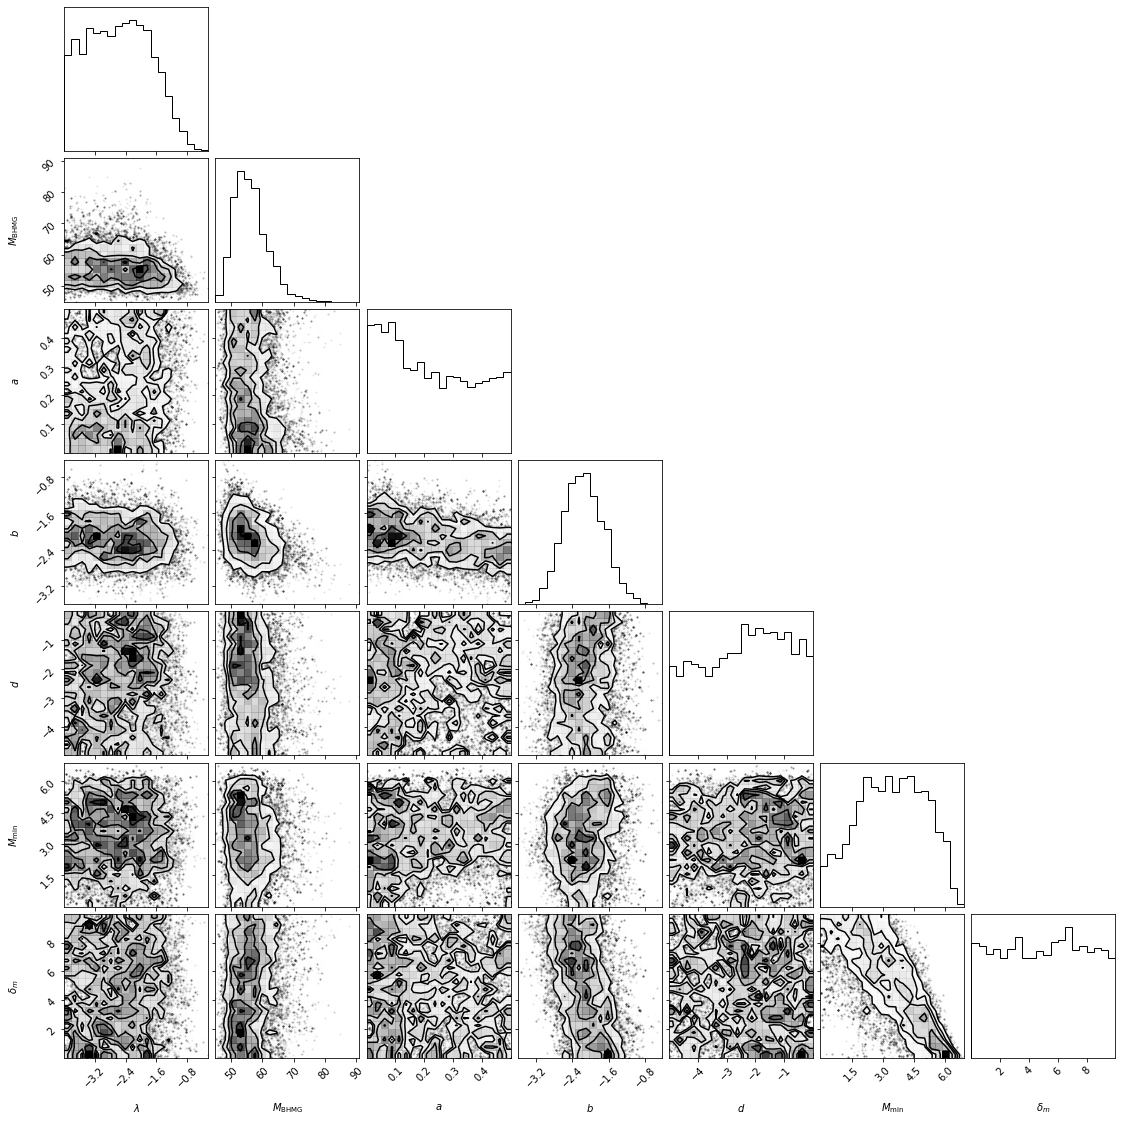

In [120]:
#        n1 = params[0]
#        np = params[1]
#        MBHMG = params[2]
#        a = params[3]
#        b = params[4]
#        c = params[5]
#        d = params[6]
#        M_min = params[7]

if (1):
    plot_run = 'IMFfidsmooth'
    #chain_IMFfidsmooth = pk.load(open('./chains/emcee/chainz_fixevents_fixcondsmooth2_newsecondphys_no190521_True_IMFfidsmooth_secondarytypephysical_800_64_7.pk','rb'))
    chain_IMFfidsmooth = pk.load(open('./chains/emcee/chainz_fixevents_areparam_fudge_newsecondphys_no190521_True_IMFfidsmooth_secondarytypephysical_500_64_7.pk','rb'))
    param_names = np.array(['$n1$','$\lambda$','$M_{\mathrm{BHMG}}$','$a$','$b$','$d$','$M_{\mathrm{ min}}$', '$\delta_m$'])
    free_indices = np.array([1,2,3,4,5,6,7])
    
    

burnin = 50
chain_to_plot = get_flattened_chain(chain_IMFfidsmooth['chain'], burnin)

fig = corner.corner(chain_to_plot, labels = param_names[free_indices])
#fig = corner.corner(sampler.get_chain(discard = 100, flat = True), labels = param_names[free_indices])
#fig.savefig('corner_fixcondsmoothing_physsecondary_exclude190521' + str(exclude_190521) + '_' + plot_run + '_secondarytype' + secondary_type + '.png')


In [75]:
#Pareto smoothed importance sampling


if (1):
    plot_run = 'IMFfidsmooth'
    #chain_IMFfidsmooth = pk.load(open('./chains/emcee/chainz_fixevents_fixcondsmooth2_newsecondphys_no190521_True_IMFfidsmooth_secondarytypephysical_800_64_7.pk','rb'))
    chain_IMFfidsmooth = pk.load(open('./chains/emcee/chainz_fixevents_areparam_fudge_newsecondphys_no190521_True_IMFfidsmooth_secondarytypephysical_500_64_7.pk','rb'))
    param_names = np.array(['$n1$','$\lambda$','$M_{\mathrm{BHMG}}$','$a$','$b$','$d$','$M_{\mathrm{ min}}$', '$\delta_m$'])
    free_indices = np.array([1,2,3,4,5,6,7])
    burnin = 50
    chain_to_plot = get_flattened_chain(chain_IMFfidsmooth['chain'], burnin)
    lnprob = get_flattened_lnlike(chain_IMFfidsmooth['lnprob'], burnin)


In [80]:
print(chain_IMFfidsmooth.keys())
print(lnprob.shape)
print(chain_to_plot.shape)

#elpd_loo = np.sum(log_loo_pi)



def get_individual_probs(chain):
    dims = chain.shape
    nsamps = 5 #ldims[0]
    output = np.zeros((nsamps, len(bh_data)))
    for ii in range(0,nsamps):
        print("ii = ", ii)
        this_p0 = chain[ii,:]
        full_p0 = np.copy(fix_param_vals)
        full_p0[free_indices] = this_p0
        for bi in range(0,len(bh_data)):
            lnlike = get_lnlikelihood(full_p0, [bh_data[bi]], param_type = run_type)
            output[ii,bi] = lnlike
    return output
            
loo_lnlike = get_individual_probs(chain_to_plot)

dict_keys(['chain', 'args', 'lnprob'])
(28800,)
(28800, 7)
ii =  0
ii =  1
ii =  2
ii =  3
ii =  4


In [83]:
loo_lnlike.shape

(5, 10)

In [310]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [81]:
# Get bestfit parameters
28800*2./3600.

16.0

dims chain =  (32000, 7)
dims lnprob =  (32000,)
in range =  [   12    31    32 ... 31964 31991 31994]
num in range =  3997
good index =  27191
good index =  12639
good index =  7580
good index =  5938
good index =  15885
n_p = -2.277828437753466 M_{BHMG} = 75.16297282881762 a = 0.027754040164781203 b = -2.4313922467810833 d = -0.6568405903436978 M_min = 3.0499741400382914 delta_m = 6.1130639935091375
(12, 500)
0.0032003558684895474


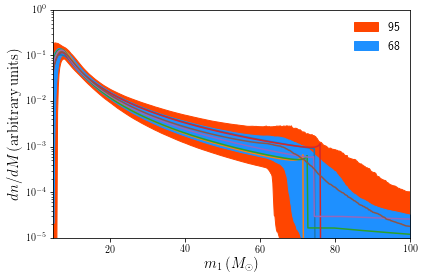

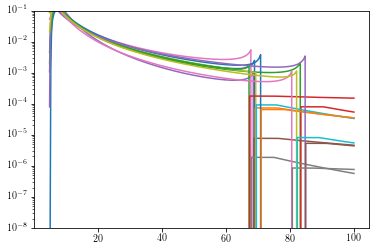

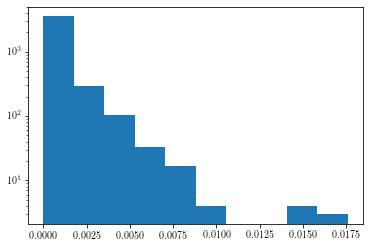

In [49]:
def get_flattened_chain(chain, burnin):
    chain_b = chain[burnin:,:,:]
    dims = chain_b.shape
    output = chain_b.reshape((dims[0]*dims[1],dims[2]))
    return output

def get_flattened_lnprob(lnprob, burnin):
    lnprob_b = lnprob[burnin:,:]
    dims = lnprob_b.shape
    output = lnprob_b.reshape((dims[0]*dims[1]))
    return output


# Make n(M) band plot
plot_run = 'IMFfidsmooth'
plot_exclude_GW190521 = False
if (plot_run == 'IMF'):
    chain_IMF = pk.load(open('./chains/emcee/chain_fixevents_IMF_1000_32_6.pk','rb'))
    plot_chain = get_flattened_chain(chain_IMF['chain'],30)
    plot_fix_params = chain_IMF['args'][1]
    plot_free_indices = chain_IMF['args'][2]
if (plot_run == 'IMFsimple'):
    #chain_IMFsimple = pk.load(open('./chains/emcee/chain_fixevents_newpriors2_IMFsimple_1500_32_5.pk','rb'))
    #chain_IMFsimple = pk.load(open('./chains/emcee/chain_fixevents_newpriors3_no190521_True_IMFsimple_1000_32_5.pk','rb'))
    chain_IMFsimple = pk.load(open('./chains/emcee/chain_fixevents_newpriors4_no190521_True_IMFsimple_1000_32_5.pk','rb'))
    plot_chain = get_flattened_chain(chain_IMFsimple['chain'],100)
    plot_fix_params = chain_IMFsimple['args'][1]
    plot_free_indices = chain_IMFsimple['args'][2]
if (plot_run == 'IMFfid'):
    if (plot_exclude_190521):
        chain = pk.load(open('./chains/emcee/chainz_fixevents_no0_no190521_True_IMFfid_800_32_5.pk','rb'))
    else:
        chain = pk.load(open('./chains/emcee/chainz_fixevents_no0_no190521_False_IMFfid_800_32_5.pk','rb'))
if (plot_run == 'IMFfidsmooth'):
    param_name_starr = np.array(['n1','n_p','M_{BHMG}','a','b','d','M_min', 'delta_m'])
    if (plot_exclude_GW190521):
        chain = pk.load(open('./chains/emcee/chainz_aaa_runtypeIMFfidsmooth_secondaryphysical_mmax0_exclude190521True_epsilontypesharp_500_64_7.pk','rb'))
    else:
        chain = pk.load(open('./chains/emcee/chainz_aaa_runtypeIMFfidsmooth_secondaryphysical_mmax0_exclude190521False_epsilontypesharp_600_64_7.pk','rb'))
    burnin = 100
if (plot_run == 'plandpeak'):
    param_name_starr = np.array(['n1','$alpha$','$M_{BHMG}$','$lambda$','delta_m','mu_m','sigma_m','M_min'])
    if (plot_exclude_GW190521):
        chain = pk.load(open('./chains/emcee/chainz_aaa_runtypeplandpeak_secondaryphysical_mmax0_exclude190521True_epsilontypesharp_500_64_7.pk','rb'))
    else:
        chain = pk.load(open('./chains/emcee/chainz_aaa_runtypeplandpeak_secondaryphysical_mmax0_exclude190521False_epsilontypesharp_800_64_7.pk','rb'))
    burnin = 100

plot_chain = get_flattened_chain(chain['chain'],burnin)
plot_fix_params = chain['args'][1]
plot_free_indices = chain['args'][2]    


min_M_plot = 5.
max_M_plot = 100.
num_M_plot = 500
M_plot = np.linspace(min_M_plot, max_M_plot, num = num_M_plot)
dM = M_plot[1:] - M_plot[:-1]

#shouldn't matter what this is, since mass func only depends on m1
m2_arb = 10.


#Get best params
n_samps = 5
lnprob = get_flattened_lnprob(chain['lnprob'], burnin)
print("dims chain = ", plot_chain.shape)
print("dims lnprob = ", lnprob.shape)
best_index = np.argmax(lnprob)
in_range = np.where(lnprob > np.max(lnprob)-1.)[0]
print("in range = ", in_range)
print("num in range = ", len(in_range))
best_dndM_mat = np.zeros((n_samps, num_M_plot))
for si in range(0,n_samps):
    good_index = in_range[np.random.randint(0,len(in_range))]
    print("good index = ", good_index)
    best_params = plot_chain[good_index,:]
    best_params_all = np.copy(plot_fix_params)
    best_params_all[plot_free_indices] = best_params
    temp, best_dndm = get_mass_distrib(M_plot, m2_arb, best_params_all, param_type = plot_run, return_dndm = True)    
    best_dndM = best_dndm/np.sum(0.5*dM*(best_dndm[1:] + best_dndm[:-1]))
    best_dndM_mat[si,:] = best_dndM
    

num_samps = 4000
permuted_indices = np.random.permutation(plot_chain.shape[0])
dndM_samps = np.zeros((num_samps, num_M_plot))
primary_samps = np.zeros((num_samps, num_M_plot))
secondary_samps = np.zeros((num_samps, num_M_plot))
frac_2g = np.zeros(num_samps)
for si in range(0,num_samps):
    params_all_si = np.copy(plot_fix_params)
    params_free_si = plot_chain[permuted_indices[si],:]
    params_all_si[plot_free_indices] = params_free_si
    temp, dndm = get_mass_distrib(M_plot, m2_arb, params_all_si, param_type = plot_run, return_dndm = True) 
    dndM_samps[si,:] = dndm/np.sum(0.5*dM*(dndm[1:] + dndm[:-1]))
    
    if (plot_run == 'IMFfidsmooth'):
        temp, primary, secondary = get_mass_distrib(M_plot, m2_arb, params_all_si, param_type = plot_run, return_1g2g = True)
        param_dict = get_param_dict(params_all_si, param_type = plot_run)
        num_in_1g = np.sum(0.5*dM*(primary[1:] + primary[:-1]))
        num_in_2g = np.sum(0.5*dM*(secondary[1:] + secondary[:-1]))
        frac_2g[si] = num_in_2g/num_in_1g
        primary_norm = primary/np.sum(0.5*dM*(dndm[1:] + dndm[:-1]))
        secondary_norm = secondary/np.sum(0.5*dM*(dndm[1:] + dndm[:-1]))   
        primary_samps[si,:] = primary_norm
        secondary_samps[si,:] = secondary_norm
    
mean_dndM = np.mean(dndM_samps, axis = 0)
mean_dndM = mean_dndM/np.sum(0.5*dM*(mean_dndM[1:] + mean_dndM[:-1]))

band_low = np.percentile(dndM_samps, 50-68/2., axis =0)
band_high = np.percentile(dndM_samps, 50+68/2., axis =0)
band_low95 = np.percentile(dndM_samps, 50-95/2., axis =0)
band_high95 = np.percentile(dndM_samps, 50+95/2., axis =0)

nm_output_dir = './n_m_data/'
nm_output_filename = nm_output_dir + 'n_m_data' + get_file_prefix(run_name, run_type = plot_run, secondary_type = secondary_type, M_max_tot_choice = M_max_tot_choice, exclude_190521 = plot_exclude_GW190521, fudge_type = fudge_type) + '.dat'
nm_output_data = np.vstack((M_plot, band_low, band_high, band_low95, band_high95, best_dndM, mean_dndM, best_dndM_mat))
temp = []
for ii in range(1,len(best_params_all)):
    temp.append(param_name_starr[ii] + " = " + str(best_params_all[ii]))
best_param_string = ' '.join(temp)
print(best_param_string)

print(nm_output_data.shape)
#np.savetxt(nm_output_filename, np.transpose(nm_output_data), header = best_param_string + '\n Mass    dndm_low68    dndm_high68    dndm_low95    dndm_high95    dndm_MAP    dndm_mean   samp1   samp2   samp3   samp4   samp5 \n ')


fig, ax = pl.subplots(1,1)
ax.fill_between(M_plot, band_low95, band_high95, color = 'orangered', label = '95% confidence')
ax.fill_between(M_plot, band_low, band_high, color = 'dodgerblue', label = '68% confidence')
for si in range(0,n_samps):
    ax.plot(M_plot, best_dndM_mat[si,:])
    
ax.plot(M_plot, mean_dndM)
ax.set_xlim((5., 100.))
ax.set_ylim((0.00001, 1.))
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$dn/dM\,(\mathrm{arbitrary\,units})$', fontsize = 15)
ax.set_xlabel('$m_1\,(M_{\odot})$', fontsize = 15)
ax.legend(frameon = False, fontsize = 12)

fig.tight_layout()
nmfig_output_dir = './n_m_data/n_m_plots/'
nmfig_output_filename = nmfig_output_dir + 'n_m_fig_' + get_file_prefix(run_name, run_type = plot_run, secondary_type = secondary_type, M_max_tot_choice = M_max_tot_choice, exclude_190521 = plot_exclude_GW190521, fudge_type = fudge_type) + '.png'
#fig.savefig(nmfig_output_filename)

fig, ax = pl.subplots(1,1)
for ii in range(0,10):
    #ax.plot(M_plot, dndM_samps[ii,:])
    if (plot_run == 'IMFfidsmooth'):
        ax.plot(M_plot, primary_samps[ii,:])
        ax.plot(M_plot, secondary_samps[ii,:])
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((0.00000001, 0.1))
#fig.savefig('n_m_linear_samples_areparam_fudge_physsecondary_exclude190521' + str(exclude_190521) + '_' + plot_run + '.png')


fig, ax = pl.subplots(1,1)
ax.hist(frac_2g)
ax.set_yscale('log')
print(np.percentile(frac_2g, 95))



0.014174963188535953


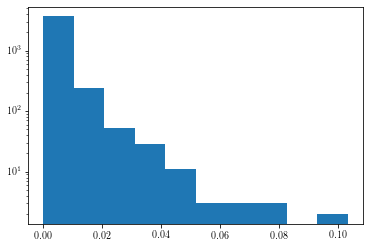

(1e-06, 10.0)

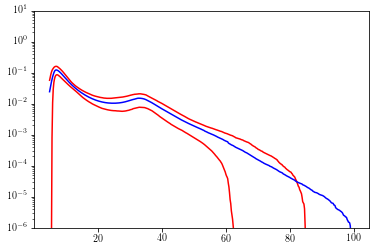

In [411]:
data = np.genfromtxt('/home/ebaxter/Dropbox/DM_BHMG_DATA/results/dndm_data/n_m_dataaaa_runtypeplandpeak_secondaryphysical_mmax0_exclude190521True_epsilontypesharp.dat')

fig,ax = pl.subplots(1,1)
ax.plot(data[:,0], data[:,1], color = 'red')
ax.plot(data[:,0], data[:,2], color = 'red')
ax.plot(data[:,0], data[:,-1], color = 'blue')
ax.set_yscale('log')
ax.set_ylim((1.0e-6, 1.0e1))

In [40]:
#1D scans

# IMF
# np.array([0.87, 0.0, 60., 0.5, -4.97, -1., 0.5, 5.0])
#        n1 = params[0]
#        np = params[1]
#        MBHMG = params[2]
#        a = params[3]
#        b = params[4]
#        c = params[5]
#        d = params[6]
#        M_min = params[7]

#1d analyses

#min_MBHMG = 10.
#max_MBHMG = 100.

min_MBHMG = 20.
max_MBHMG = 100.


min_a = 0.
max_a = 1.0

min_b = -6
max_b = 0.

min_c = -2.
max_c = 10.

min_d = 0.1
max_d = 2.0

num = 20

MBHMG_arr = np.linspace(min_MBHMG, max_MBHMG, num = num*3)
a_arr = np.linspace(min_a, max_a, num = num)
b_arr = np.linspace(min_b, max_b, num = num)
c_arr = np.linspace(min_c, max_c, num = num)
d_arr = np.linspace(min_d, max_d, num = num)

print("running a")
lnpost_a = np.zeros((num))
for ai in range(0,num):
    print("ai = ", ai)
    p0 = np.copy(fix_param_vals)
    p0[3] = a_arr[ai]
    lnpost_a[ai] = get_lnposterior(p0, bh_data, param_type = run_type)

'''

print("running MBHMG")
lnpost_MBHMG = np.zeros(len(MBHMG_arr))
for ai in range(0,len(MBHMG_arr)):
    #print("ai = ", ai)
    p0 = np.copy(fix_param_vals)
    p0[2] = MBHMG_arr[ai]
    lnpost_MBHMG[ai] = get_lnposterior(p0, bh_data, param_type = run_type)


print("running b")    
lnpost_b = np.zeros((num))
for ai in range(0,num):
    #print("bi = ",ai)
    p0 = np.copy(fix_param_vals)
    p0[4] = b_arr[ai]
    lnpost_b[ai] = get_lnposterior(p0, bh_data, param_type = run_type)

if (run_type == 'IMF'):
    print("running c")    
    lnpost_c = np.zeros((num))
    for ai in range(0,num):
        #arint("ci = ",ai)
        p0 = np.copy(fix_param_vals)
        p0[5] = c_arr[ai]
        lnpost_c[ai] = get_lnposterior(p0, bh_data, param_type = run_type)

print("running d")    
lnpost_d = np.zeros((num))
for ai in range(0,num):
    #arint("ci = ",ai)
    p0 = np.copy(fix_param_vals)
    if (run_type == 'IMF'):
        p0[6] = d_arr[ai]
    if (run_type == 'IMFsimple'):
        p0[5] = d_arr[ai]
        
    lnpost_d[ai] = get_lnposterior(p0, bh_data, param_type = run_type)

'''

running a
ai =  0
ai =  1


/home/ebaxter/anaconda2/envs/mypython3/lib/python3.7/site-packages/ipykernel_launcher.py:309: RuntimeWarning: invalid value encountered in double_scalars
/home/ebaxter/anaconda2/envs/mypython3/lib/python3.7/site-packages/ipykernel_launcher.py:309: RuntimeWarning: invalid value encountered in power


ai =  2
ai =  3
ai =  4
ai =  5
ai =  6
ai =  7
ai =  8
ai =  9
ai =  10
ai =  11
ai =  12
ai =  13
ai =  14
ai =  15
ai =  16
ai =  17
ai =  18
ai =  19


'\n\nprint("running MBHMG")\nlnpost_MBHMG = np.zeros(len(MBHMG_arr))\nfor ai in range(0,len(MBHMG_arr)):\n    #print("ai = ", ai)\n    p0 = np.copy(fix_param_vals)\n    p0[2] = MBHMG_arr[ai]\n    lnpost_MBHMG[ai] = get_lnposterior(p0, bh_data, param_type = run_type)\n\n\nprint("running b")    \nlnpost_b = np.zeros((num))\nfor ai in range(0,num):\n    #print("bi = ",ai)\n    p0 = np.copy(fix_param_vals)\n    p0[4] = b_arr[ai]\n    lnpost_b[ai] = get_lnposterior(p0, bh_data, param_type = run_type)\n\nif (run_type == \'IMF\'):\n    print("running c")    \n    lnpost_c = np.zeros((num))\n    for ai in range(0,num):\n        #arint("ci = ",ai)\n        p0 = np.copy(fix_param_vals)\n        p0[5] = c_arr[ai]\n        lnpost_c[ai] = get_lnposterior(p0, bh_data, param_type = run_type)\n\nprint("running d")    \nlnpost_d = np.zeros((num))\nfor ai in range(0,num):\n    #arint("ci = ",ai)\n    p0 = np.copy(fix_param_vals)\n    if (run_type == \'IMF\'):\n        p0[6] = d_arr[ai]\n    if (run_type

"\n\nfig, ax = pl.subplots(1,1)\nax.plot(MBHMG_arr, np.exp(lnpost_MBHMG - np.max(lnpost_MBHMG)))\nax.set_xlabel('MBHMG')\nax.set_ylabel('posterior')  \nfig.tight_layout()\n#fig.savefig('./IMFplots/post_MBHMG_data' + data_type + '.png')\n\nfig, ax = pl.subplots(1,1)\nax.plot(b_arr, np.exp(lnpost_b - np.max(lnpost_b)))\nax.set_xlabel('b')\nax.set_ylabel('posterior')\nfig.tight_layout()\n#fig.savefig('./IMFplots/post_b_data' + data_type + '.png')\n\nif (run_type == 'IMF'):\n    fig, ax = pl.subplots(1,1)\n    ax.plot(c_arr, np.exp(lnpost_c - np.max(lnpost_c)))\n    ax.set_xlabel('c')\n    ax.set_ylabel('posterior')\n    fig.tight_layout()\n    #fig.savefig('./IMFplots/post_c_data' + data_type + '.png')\n\nfig, ax = pl.subplots(1,1)\nax.plot(d_arr, np.exp(lnpost_d - np.max(lnpost_d)))\nax.set_xlabel('d')\nax.set_ylabel('posterior')\nfig.tight_layout()\n#fig.savefig('./IMFplots/post_d_data' + data_type + '.png')\n"

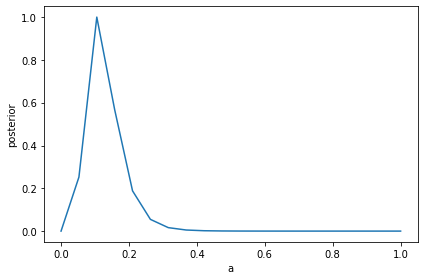

In [41]:
fig, ax = pl.subplots(1,1)
ax.plot(a_arr, np.exp(lnpost_a - np.max(lnpost_a)))
ax.set_xlabel('a')
ax.set_ylabel('posterior')
#ax.set_yscale('log')
#ax.set_xlim((-5., 2.))
fig.tight_layout()

#fig.savefig('./IMFplots/post_a_data' + data_type + '.png')

'''

fig, ax = pl.subplots(1,1)
ax.plot(MBHMG_arr, np.exp(lnpost_MBHMG - np.max(lnpost_MBHMG)))
ax.set_xlabel('MBHMG')
ax.set_ylabel('posterior')  
fig.tight_layout()
#fig.savefig('./IMFplots/post_MBHMG_data' + data_type + '.png')

fig, ax = pl.subplots(1,1)
ax.plot(b_arr, np.exp(lnpost_b - np.max(lnpost_b)))
ax.set_xlabel('b')
ax.set_ylabel('posterior')
fig.tight_layout()
#fig.savefig('./IMFplots/post_b_data' + data_type + '.png')

if (run_type == 'IMF'):
    fig, ax = pl.subplots(1,1)
    ax.plot(c_arr, np.exp(lnpost_c - np.max(lnpost_c)))
    ax.set_xlabel('c')
    ax.set_ylabel('posterior')
    fig.tight_layout()
    #fig.savefig('./IMFplots/post_c_data' + data_type + '.png')

fig, ax = pl.subplots(1,1)
ax.plot(d_arr, np.exp(lnpost_d - np.max(lnpost_d)))
ax.set_xlabel('d')
ax.set_ylabel('posterior')
fig.tight_layout()
#fig.savefig('./IMFplots/post_d_data' + data_type + '.png')
'''